# Imports

Инструкции по настройке виртуально окружения можно найти в файле README. Нужные python-пакеты можно найти в файле requirements.txt

## Python пакеты

In [ ]:
#!pip uninstall -y pandas
!pip install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.6.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.9.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import os
from glob import glob
import copy
import sys
import scipy

import matplotlib.pyplot as plt

In [ ]:
pd.__version__

'1.5.3'

для работы c R

In [ ]:
import rpy2
%load_ext rpy2.ipython
print(rpy2.__version__)

3.4.2


In [ ]:
%load_ext autoreload
%load_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 150)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## R пакеты

In [ ]:
%%R

(!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install("edgeR")
BiocManager::install("DESeq2")
BiocManager::install("biomaRt")
BiocManager::install("fgsea")
BiocManager::install("ComplexHeatmap") # для всех пакетов из bioconductor

install.packages("ggrepel")
install.packages("circlize")
# для отсальных пакетов (не из Bioconductor)

(as ‘lib’ is unspecified)







	‘/tmp/RtmppQ9djB/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com































	‘/tmp/RtmppQ9djB/downloaded_packages’




Update all/some/none? [a/s/n]: 












	‘/tmp/RtmppQ9djB/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com








































































































































	‘/tmp/RtmppQ9djB/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com



















































	‘/tmp/RtmppQ9djB/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com





















	‘/tmp/RtmppQ9djB/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
























































	‘/tmp/RtmppQ9djB/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/t

In [ ]:
%%R
BiocManager::install("ComplexHeatmap")
suppressMessages(library(edgeR)) #bioconductor package
suppressMessages(library(ggplot2))
suppressMessages(library(DESeq2)) #bioconductor package
suppressMessages(library(biomaRt)) #bioconductor package
suppressMessages(library(ggrepel))
suppressMessages(library(fgsea))
suppressMessages(library(limma))
suppressMessages(library(matrixStats))
suppressMessages(library(circlize))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(data.table))

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com




# Obtaining gene counts

Идем на сайт xena, чтобы добыть каунтов для TCGA когорты с образцами тимомы. https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Thymoma%20(THYM)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

заметим, что они в log2(count+1)

In [ ]:
!wget https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-THYM.htseq_counts.tsv.gz

--2024-10-12 07:41:34--  https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-THYM.htseq_counts.tsv.gz
Resolving gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)... 52.216.38.154, 52.217.81.208, 52.216.41.82, ...
Connecting to gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)|52.216.38.154|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-10-12 07:41:35 ERROR 403: Forbidden.



In [ ]:
expr_counts = pd.read_csv('TCGA-THYM.htseq_counts.tsv.gz', sep = '\t', index_col=0)
#we see some technical info
expr_counts.head(-2)

FileNotFoundError: [Errno 2] No such file or directory: 'TCGA-THYM.htseq_counts.tsv.gz'

Видим техническую информацию о log2(числе ридов + 1), которые 1) __no_feature - замапились не всей длиной рида 2) __ambiguous - замапились больше чем на один ген 3) __too_low_aQual - качество выравнивания ниже порога. Удалим ее

In [ ]:
expr_counts = expr_counts.loc[[ind for ind in expr_counts.index if ind.startswith('ENS')]]
display(expr_counts.shape)

они log2(X + 1), нужно обратное преобразование

In [ ]:
sns.distplot(expr_counts.T.mean())
plt.show()

In [ ]:
expr_counts = pow(2, expr_counts) - 1

In [ ]:
sns.distplot(expr_counts.T.mean())
plt.show()

In [ ]:
expr_counts.head(2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
plt.scatter(expr_counts.T.mean(), expr_counts.T.std())
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean')
ax.set_ylabel('dispersion')

## Ensembl ID to Gene

Ensembl - https://www.ensembl.org/index.html
ENSG = Gene ENST = Transcript https://asia.ensembl.org/Help/Faq?id=488

Refseq - https://www.ncbi.nlm.nih.gov/refseq/
NG_.... - gene NM = transcript

Gencode - https://www.gencodegenes.org/human/

идем еще раз на сайт xena https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Thymoma%20(THYM)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

In [ ]:
# load correspondence table for renaming gene ids into gene names
!wget https://gdc-hub.s3.us-east-1.amazonaws.com/download/gencode.v22.annotation.gene.probeMap

In [ ]:
df_gene_names = pd.read_csv('gencode.v22.annotation.gene.probeMap', sep = '\t')
df_gene_names.head()

In [ ]:
dict_gene_names = dict(zip(*df_gene_names[['id', 'gene']].values.T))

# # replace gene ids -> gene names
expr_counts.index = pd.Series(expr_counts.index).map(dict_gene_names).fillna(pd.Series(expr_counts.index))

In [ ]:
display(expr_counts.shape)
expr_counts.head(3)

In [ ]:
expr_counts = expr_counts.astype(int)

## Gene selection

Выберем из gtf гены с половых хромосом, выкинем их рассмотрения (в случае дисбаланса в выборке, они могут определиться как дифференциально экспрессированные, это можно скорректировать, учтя пол в модели, но для простоты я здесь их просто выброшу)

In [ ]:
!pip install gtfparse==1.3.0
from gtfparse import read_gtf

качать отсюда https://www.gencodegenes.org/human/release_29.html

In [ ]:
pd.__version__

In [ ]:
df = read_gtf("gencode.v29.annotation.gtf")

In [ ]:
df.head(2)

In [ ]:
df = df[['seqname','gene_name', 'gene_type']].drop_duplicates()

In [ ]:
df.head(2)

In [ ]:
df['gene_type'].unique()

In [ ]:
sex_genes = df[df.seqname.isin(["chrX", "chrY"])].gene_name.unique()

In [ ]:
target_genes = list(set(df[df.gene_type=="protein_coding"].gene_name) - set(sex_genes))

In [ ]:
len(target_genes)

можно сдела то же самое с помощью biomaRt

In [ ]:
# %%R -i df -o tmp_ids
# # get biotypes to select protein-coding genes
# mart <- useMart(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
# tmp_ids <- getBM(attributes = c("hgnc_symbol", "gene_biotype"),
#           filters = "hgnc_symbol",
#           values = rownames(expr_counts),
#           mart = mart)
# tmp_ids <- as.data.frame(tmp_ids)

In [ ]:
# tmp_ids.head(2)

In [ ]:
# # #tmp_ids.to_csv("./biotypes.tsv", sep="\t")
# tmp_ids = pd.read_csv("biotypes.tsv", sep="\t")

In [ ]:
# remove non-coding
expr_counts = expr_counts.loc[set(target_genes) & set(expr_counts.index)]
display(expr_counts.shape)
expr_counts.head(3)

In [ ]:
expr_counts.index.value_counts().head()

некоторым генам соответствуют больше одного ensemble ID (почему?).

Многие гены кодируют не один белок, а несколько изоформ (альтернативных форм белка), которые возникают в результате альтернативного сплайсинга. Каждый из этих транскриптов может иметь свой Ensembl ID.

In [ ]:
expr_counts = expr_counts.iloc[~expr_counts.index.duplicated()]
expr_counts.shape

https://asia.ensembl.org/info/genome/genebuild/haplotypes_patches.html

# Load annotation

In [ ]:
ann = pd.read_csv('THYM_ann_short.tsv', sep = '\t', index_col = 0)
#ann.index = ann['Sample ID']

In [ ]:
ann.head(2)

Patient_ID        Sample_ID  Aneuploidy_score  \
Sample ID                                                           
TCGA-3G-AB0O-01A  TCGA-3G-AB0O  TCGA-3G-AB0O-01               0.0   
TCGA-3G-AB0Q-01A  TCGA-3G-AB0Q  TCGA-3G-AB0Q-01               0.0   

                 Neoadjuvant_therapy_before_resection  Mutation_count Relapse  \
Sample ID                                                                       
TCGA-3G-AB0O-01A                                   No              10      No   
TCGA-3G-AB0Q-01A                                  Yes              23      No   

                 Sample_type    Site         Histology MG_status  
Sample ID                                                         
TCGA-3G-AB0O-01A     Primary  Thymus  Thymoma, Type B1        NO  
TCGA-3G-AB0Q-01A     Primary  Thymus   Thymoma, Type A       NaN

In [ ]:
ann['Histology'].value_counts()

Thymoma, Type Ab                     38
Thymoma, Type B2                     27
Thymoma, Type A                      15
Thymoma, Type B1                     14
Thymoma, Type B3                     12
Thymoma, Type C                      11
Thymoma, Type B2|Thymoma, Type B3     3
Thymoma, Type A|Thymoma, Type Ab      2
Thymoma, Type B1|Thymoma, Type B2     1
Name: Histology, dtype: int64

In [ ]:
ann['Relapse'].value_counts()

No     107
Yes     14
Name: Relapse, dtype: int64

In [ ]:
ann['MG_status'].value_counts()

NO     82
YES    31
Name: MG_status, dtype: int64

Какие закономерности есть в распределениях?

In [ ]:
ann = ann[(ann['Histology'] != 'Thymoma, Type B1|Thymoma, Type B2') &
          (ann['Histology'] != 'Thymoma, Type A|Thymoma, Type Ab') &
         (ann['Histology'] != 'Thymoma, Type B2|Thymoma, Type B3')]

R не переваривает пробелы в названиях, так что уберем их

In [ ]:
ann['Histology'].unique()

array(['Thymoma, Type B1', 'Thymoma, Type A', 'Thymoma, Type B2',
       'Thymoma, Type C', 'Thymoma, Type B3', 'Thymoma, Type Ab'],
      dtype=object)

In [ ]:
ann['Histology'] = ann['Histology'].replace({'Thymoma, Type Ab':'Ab',
                                            'Thymoma, Type B1':'B1',
                                            'Thymoma, Type A':'A',
                                           'Thymoma, Type B2':'B2',
                                            'Thymoma, Type B3':'B3',
                                            'Thymoma, Type C':'C'})

Обязательно надо проверить, что образцы совпадают между таблицей экспрессии и аннотацией, иначеничего работать не будет:

In [ ]:
expr = expr_counts[set(ann.index) & set(expr_counts.columns)]
expr.index.name = None
ann = ann.loc[expr.columns]

display(expr.shape)
display(ann.shape)

(17765, 112)

(112, 10)

In [ ]:
ann.head(2)

Patient_ID        Sample_ID  Aneuploidy_score  \
TCGA-XM-A8RB-01A  TCGA-XM-A8RB  TCGA-XM-A8RB-01               0.0   
TCGA-ZB-A96F-01A  TCGA-ZB-A96F  TCGA-ZB-A96F-01              16.0   

                 Neoadjuvant_therapy_before_resection  Mutation_count Relapse  \
TCGA-XM-A8RB-01A                                   No               4      No   
TCGA-ZB-A96F-01A                                   No              22      No   

                 Sample_type    Site Histology MG_status  
TCGA-XM-A8RB-01A     Primary  Thymus        B1        NO  
TCGA-ZB-A96F-01A     Primary  Thymus        Ab       YES

In [ ]:
expr.head(2)

TCGA-XM-A8RB-01A  TCGA-ZB-A96F-01A  TCGA-ZC-AAAA-01A  TCGA-ZB-A96P-01A  \
TFAM              2615              1979              2438              5249   
NCR3               231               187               417               212   

      TCGA-ZC-AAAF-01A  TCGA-XM-A8RC-01A  TCGA-XU-A92Z-01A  TCGA-X7-A8DD-01A  \
TFAM              1329              5151              3219              1293   
NCR3                72               130                 2               178   

      TCGA-X7-A8DG-01A  TCGA-4V-A9QL-01A  TCGA-ZB-A963-01A  TCGA-4V-A9QW-01A  \
TFAM              1903              3012              3520              1198   
NCR3               264               373               159               221   

      TCGA-ZB-A969-01A  TCGA-XU-AAY1-01A  TCGA-ZB-A96V-01A  TCGA-XU-A933-01A  \
TFAM              4809              1962              2290              5979   
NCR3                41               213                85                38   

      TCGA-3S-AAYX-01A  TCGA-XU-A92Q-01A  TCGA-XH-A853-01A  TCGA-4V-A9QT-01A  \
TFAM              3575              2423              3171              4060   
NCR3               181               152               272               164   

      TCGA-YT-A95H-01A  TCGA-YT-A95F-01A  TCGA-ZB-A96M-01A  TCGA-XU-AAXY-01A  \
TFAM              3594              3873              4067              1325   
NCR3                91                55               273               501   

      TCGA-3S-A8YW-01A  TCGA-YT-A95D-01A  TCGA-3G-AB19-01A  TCGA-4V-A9QN-01A  \
TFAM              3016              2222              4838              2284   
NCR3                15               202               172                12   

      TCGA-XM-A8RL-01A  TCGA-4X-A9FA-01A  TCGA-ZB-A96C-01A  TCGA-XU-A92Y-01A  \
TFAM              3644              1939              3266              2949   
NCR3               221               373               141               168   

      TCGA-4V-A9QJ-01A  TCGA-4V-A9QU-01A  TCGA-ZC-AAAH-01A  TCGA-3Q-A9WF-01A  \
TFAM              2350              2135              1413              1379   
NCR3               149                29               230               164   

      TCGA-X7-A8DF-01A  TCGA-XM-A8RI-01A  TCGA-X7-A8M6-01A  TCGA-X7-A8M3-01A  \
TFAM              2161              2383               712              1629   
NCR3               252               192               157                10   

      TCGA-XU-A92V-01A  TCGA-X7-A8D8-01A  TCGA-XU-A931-01A  TCGA-X7-A8M4-01A  \
TFAM              3185              3601              2672              2501   
NCR3               134               167                63               215   

      TCGA-ZB-A96O-01A  TCGA-XU-AAY0-01A  TCGA-X7-A8DJ-01A  TCGA-ZB-A96G-01A  \
TFAM              1384               994              3670              1926   
NCR3               212               132               323               174   

      TCGA-X7-A8M7-01A  TCGA-3T-AA9L-01A  TCGA-4V-A9QX-01A  TCGA-5V-A9RR-01A  \
TFAM               884              1997              3559              1357   
NCR3               228                78               161               127   

      TCGA-XU-A92U-01A  TCGA-YT-A95E-01A  TCGA-XU-A936-01A  TCGA-XM-A8RD-01A  \
TFAM              3243              2496              2028              2741   
NCR3               113               102               204               185   

      TCGA-XM-A8RE-01A  TCGA-XU-A92W-01A  TCGA-ZL-A9V6-01A  TCGA-XM-A8R8-01A  \
TFAM              2939              2666              3506              1180   
NCR3               207                54               106               508   

      TCGA-XM-A8RF-01A  TCGA-ZB-A96D-01A  TCGA-XM-A8RG-01A  TCGA-3G-AB0O-01A  \
TFAM              4172              2706              2853              2506   
NCR3                75               164                40               196   

      TCGA-4V-A9QR-01A  TCGA-XU-AAXX-01A  TCGA-ZB-A96K-01A  TCGA-ZB-A96L-01A  \
TFAM              1227              2555              2639            

# Load FPKM, FPKM -> TPM

In [ ]:
!wget https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-THYM.htseq_fpkm.tsv.gz

--2024-10-11 14:45:00--  https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-THYM.htseq_fpkm.tsv.gz
Resolving gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)... 54.231.134.58, 52.217.203.42, 52.217.136.162, ...
Connecting to gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)|54.231.134.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36506376 (35M) [text/tab-separated-values]
Saving to: ‘TCGA-THYM.htseq_fpkm.tsv.gz’

TCGA-THYM.htseq_fpk 100%[===================>]  34.81M  16.1MB/s    in 2.2s    

2024-10-11 14:45:02 (16.1 MB/s) - ‘TCGA-THYM.htseq_fpkm.tsv.gz’ saved [36506376/36506376]



In [ ]:
expr_fpkm = pd.read_csv('TCGA-THYM.htseq_fpkm.tsv.gz', sep = '\t', index_col=0)
expr_fpkm.shape

(60483, 121)

In [ ]:
# log2 to numbers
expr_fpkm = pow(2, expr_fpkm) - 1

# replace gene ids -> gene names
expr_fpkm.index = pd.Series(expr_fpkm.index).map(dict_gene_names).fillna(pd.Series(expr_fpkm.index))

# filter genes
expr_fpkm = expr_fpkm.loc[set(target_genes) & set(expr_fpkm.index)]
expr_fpkm = expr_fpkm.iloc[~expr_fpkm.index.duplicated()]

# select samples
expr_fpkm = expr_fpkm[set(ann.index) & set(expr_fpkm.columns)]
expr_fpkm.index.name = None

print(expr_fpkm.shape)

(17765, 112)


In [ ]:
expr_tpm = expr_fpkm / expr_fpkm.sum() * 1e6

In [ ]:
expr_tpm.sum()

TCGA-XM-A8RB-01A    1000000.0
TCGA-ZB-A96F-01A    1000000.0
TCGA-ZC-AAAA-01A    1000000.0
TCGA-ZB-A96P-01A    1000000.0
TCGA-ZC-AAAF-01A    1000000.0
                      ...    
TCGA-XU-A930-01A    1000000.0
TCGA-3G-AB0Q-01A    1000000.0
TCGA-XM-A8R9-01A    1000000.0
TCGA-X7-A8M1-01A    1000000.0
TCGA-ZC-AAA7-01A    1000000.0
Length: 112, dtype: float64

<Axes: ylabel='Density'>

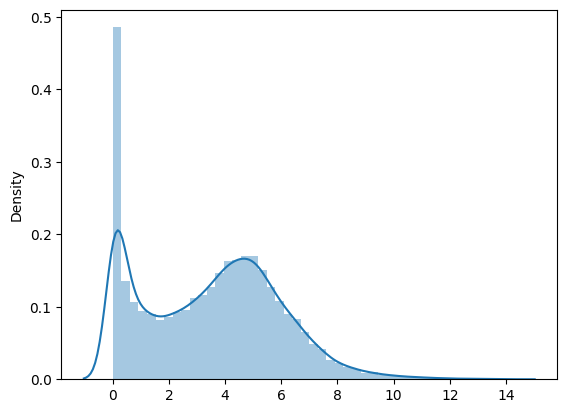

In [ ]:
sns.distplot(np.log2(expr_tpm.T.mean() + 1))

# Biological batches and other stuff

In [ ]:
from sklearn.decomposition import PCA

Когда смотрим батчи на PCA, изпользуем TPM/FPKM - на каунтах можно увидеть в целом что угодно (в том числе ложные закономерности)

In [ ]:
#for counts

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann.loc[ann.index == i, 'Histology'].values[0] for i in expr.columns]
color_mg = [ann.loc[ann.index == i, 'MG_status'].values[0] for i in expr.columns]

<Axes: xlabel='PC1', ylabel='PC2'>

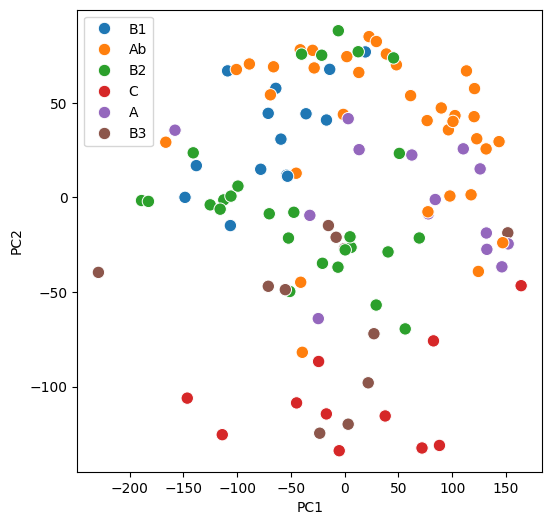

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

так выглядит правильный PCA для того, чтобы посмотреть на биологические батчи. А что такое технический батч?

<Axes: xlabel='PC1', ylabel='PC2'>

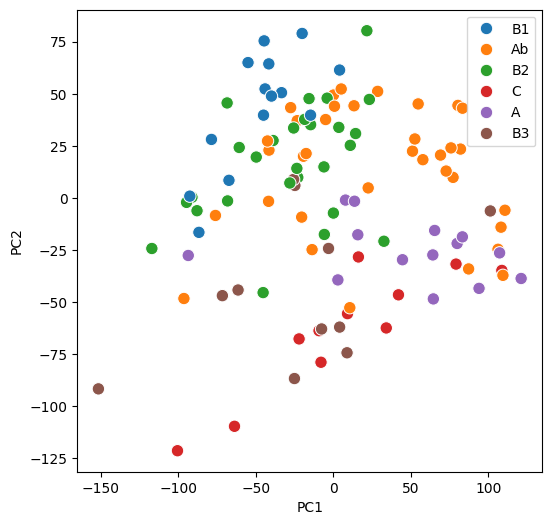

In [ ]:
#for tpm

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr_tpm+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann.loc[ann.index == i, 'Histology'].values[0] for i in expr.columns]
color_mg = [ann.loc[ann.index == i, 'MG_status'].values[0] for i in expr.columns]

plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

In [ ]:
pca_expr.explained_variance_ratio_

array([0.29028374, 0.14915188])

<Axes: xlabel='PC1', ylabel='PC2'>

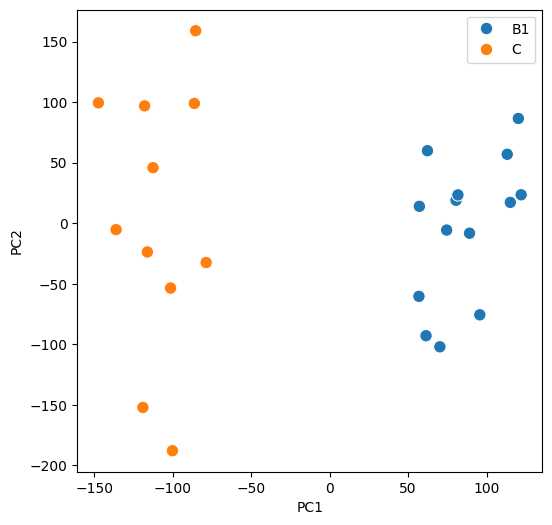

In [ ]:
#for tpm C and B1 only
ann_sel = ann[(ann['Histology'] == 'B1') | (ann['Histology'] == 'C')]
expr_tpm_sel = expr[ann_sel.index]

pca_expr = PCA(n_components=2)
PCs = pca_expr.fit_transform(np.log2(expr_tpm_sel+1).T)
pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
color_hist = [ann_sel.loc[ann_sel.index == i, 'Histology'].values[0] for i in expr_tpm_sel.columns]
color_mg = [ann_sel.loc[ann_sel.index == i, 'MG_status'].values[0] for i in expr_tpm_sel.columns]

plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_expr_df, x = "PC1", y = "PC2", hue = color_hist, s=80)

In [ ]:
pca_expr.explained_variance_ratio_ * 100

array([30.59896103, 20.41675999])

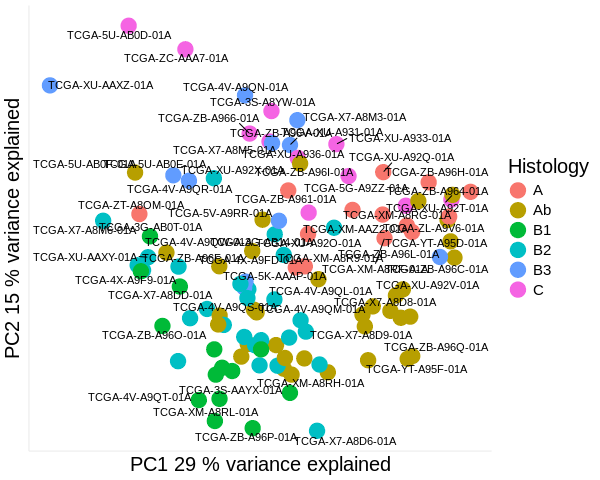

In [ ]:
%%R -w 600 -i expr_tpm -i ann
expr_tpm_log = log(expr_tpm + 1, 2)
a <- prcomp(t(expr_tpm_log))
PC1_var <- round((summary(a)[[6]][2,1])*100)
PC2_var <- round((summary(a)[[6]][2,2])*100)
a <- as.data.frame(a$x[,1:2])
a$Patient  <- rownames(ann)
a$Histology <- factor(ann$Histology)
p1 <- ggplot(data=a, aes(x=PC1,y=PC2), dpi=300)+
    geom_point(aes(color=Histology), alpha=1, size=7)+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=20),
         axis.title.y = element_text(size=20),
         legend.text = element_text(size = 15), legend.title = element_text(size=20),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab(paste("PC1", PC1_var, "% variance explained"))+
    ylab(paste("PC2", PC2_var, "% variance explained"))+
    geom_text_repel(data=a, aes(label=Patient))
p1

In [ ]:
#drop one sample
ann = ann.drop(index = ('TCGA-XU-AAXZ-01A'))
expr = expr.drop(columns = ('TCGA-XU-AAXZ-01A'))
expr_tpm = expr_tpm.drop(columns = ('TCGA-XU-AAXZ-01A'))

In [ ]:
# #drop 2 samples more
ann = ann.drop(index = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr = expr.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr_tpm = expr_tpm.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])
expr_fpkm = expr_fpkm.drop(columns = ['TCGA-ZC-AAA7-01A','TCGA-5U-AB0D-01A'])

In [ ]:
expr_tpm.shape

(17765, 109)

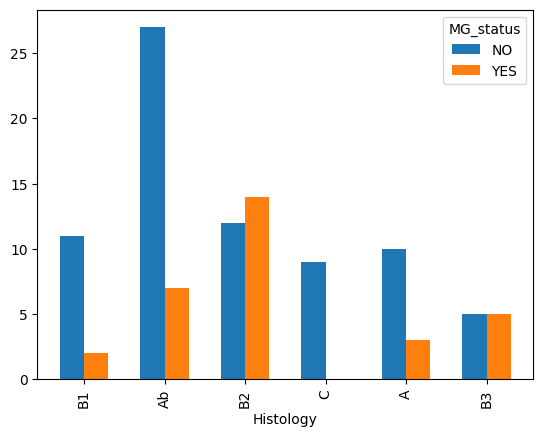

p_value = 0.006870247255942192


In [ ]:
df = ann[['MG_status', 'Histology']].dropna()

groups = list(df['Histology'].unique())
markers = list(df['MG_status'].unique())

for i, marker in enumerate(markers):

    d = df[df['MG_status'] == marker]
    d = d['Histology'].value_counts()
    d = d.reindex(groups)

    width = 0.3
    x = np.arange(len(d)) - width / 2 + i * width
    plt.bar(x, d, width=width, label=marker)

plt.xticks(np.arange(len(groups)), groups, rotation=90)
plt.xlabel('Histology')
plt.legend(title='MG_status')
plt.show()

df_crosstab = pd.crosstab(df['MG_status'], df['Histology'], margins=False)
chi2, p, dof, ex = scipy.stats.chi2_contingency(df_crosstab)
print("p_value = {}".format(p))

In [ ]:
pat = ann[ann['Histology'] == 'C'].index[1]

In [ ]:
np.log2(expr_tpm.T.mean() + 1).sort_values(ascending = False)[:20]

MT-CO3     13.967893
MT-CO2     13.839690
MT-CO1     13.601827
MT-ND4     13.396544
TMSB10     13.370787
MT-ND3     13.133317
MT-ATP6    13.073218
ACTB       12.858645
RPS12      12.842966
CCL25      12.822625
FTL        12.787282
RPS11      12.690018
MT-CYB     12.672178
MT-ND1     12.565570
RPL13A     12.472863
RPS27      12.466448
MT-ND2     12.368193
PLTP       12.340141
ACTG1      12.244341
RPS18      12.141792
dtype: float64

In [ ]:
np.log2(expr_tpm.T.loc['TCGA-ZB-A963-01A'] + 1).sort_values(ascending = False)[:20]

MT-CO2     14.388766
MT-ND4     14.343739
MT-CO3     14.297221
MT-CO1     14.256052
MT-ATP6    13.715576
MT-ND3     13.631127
MT-CYB     13.407436
MT-ND1     13.288929
MT-ND4L    12.912353
MT-ATP8    12.903796
MT-ND2     12.893709
ACTB       12.784321
TMSB10     12.736128
FTL        12.638711
RPS12      12.392517
KRT14      12.321245
ACTG1      12.158212
MT-ND6     12.109800
KRT5       12.105601
RPS11      12.096812
Name: TCGA-ZB-A963-01A, dtype: float64

<Axes: ylabel='Density'>

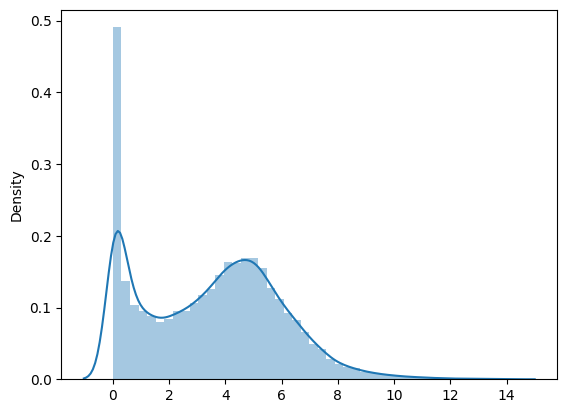

In [ ]:
sns.distplot(np.log2(expr_tpm.T.mean() + 1))

In [ ]:
expr_tpm = expr_tpm[~expr_tpm.index.str.startswith('MT-')]
expr_fpkm = expr_fpkm[~expr_fpkm.index.str.startswith('MT-')]
expr = expr[~expr.index.str.startswith('MT-')]

Какие можно сделать выводы?

# What is GLM

Проблема ненормальности остатков, нелинейности зависимости и гетероскедастичнсоти.

$$g(E(y_i))=g(\mu_i)=\beta_0+\beta_1x_1+...+\beta_nx_n$$

$$y_i\sim\text{exponential family distribution}({\overrightarrow\theta})$$

$g$ - функция связи (link-funtion)

GLM состоит из 3 частей:
* Фиксированная часть - линейная комбинация предикторов
* Случайная часть - переменная отклика распределенная в соотвествии с распределением из семейства экспоененциальных
* Функция связи - функция связывающая (линеаризующая) мат.ожидание распределения отклика с линейной комбинацией предикторов

Коэффициенты оценивают с помощью метода максимального правдоподобия (MLE).

Значимость предикторов оценивают с помощью

- теста Вальда

- теста соотношения правдоподобий (likelihood ratio test, LRT)

In [ ]:
# linear regression - normal distribution
%%R -i ann
fit <- glm(Mutation_count ~ MG_status + factor(Histology), data=ann, family="gaussian")
summary(fit)


Call:
glm(formula = Mutation_count ~ MG_status + factor(Histology), 
    family = "gaussian", data = ann)

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)          21.2512    16.0897   1.321  0.18964   
MG_statusYES          2.5782    13.2350   0.195  0.84595   
factor(Histology)Ab  -3.4879    18.5761  -0.188  0.85145   
factor(Histology)B1 -14.1094    22.3637  -0.631  0.52957   
factor(Histology)B2 -12.5625    19.7714  -0.635  0.52666   
factor(Histology)B3  -0.4403    24.2210  -0.018  0.98553   
factor(Histology)C   71.9710    24.8865   2.892  0.00472 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3244.134)

    Null deviance: 370582  on 104  degrees of freedom
Residual deviance: 317925  on  98  degrees of freedom
  (4 observations deleted due to missingness)
AIC: 1155.6

Number of Fisher Scoring iterations: 2



# DE analysis

## edgeR

https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf

На вход edgeR принимает таблицу каунтов и таблицу с разметкой групп

In [ ]:
%%R -i ann
ann$MG_status <- factor(ann$MG_status, levels=c('YES','NO'))

In [ ]:
ann['Histology'].value_counts()

Ab    35
B2    27
B1    14
A     14
B3    10
C      9
Name: Histology, dtype: int64

In [ ]:
%%R -i ann
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B3")
print(ann$Histology)

  [1] B1 Ab B2 B1 Ab B2 C  B1 B2 Ab Ab Ab C  Ab C  C  B1 A  Ab B1 Ab Ab Ab B2 C 
 [26] Ab A  B3 B1 A  Ab B3 B3 Ab B2 B2 Ab B2 B2 B3 Ab Ab B3 B2 B1 Ab Ab Ab B2 B1
 [51] Ab Ab B2 B2 C  B2 Ab Ab Ab C  A  Ab A  B1 B3 B2 Ab B3 B2 B1 C  Ab B2 B2 B1
 [76] B2 A  Ab Ab A  A  A  Ab B2 B2 B1 B2 Ab B2 Ab Ab B1 B3 A  B2 A  B2 C  Ab B3
[101] B2 B1 B2 A  B2 B3 A  A  Ab
Levels: B3 Ab B1 A B2 C


In [ ]:
%%R
design <- model.matrix(~Histology, data=ann) #+Time
head(design)

                 (Intercept) HistologyAb HistologyB1 HistologyA HistologyB2
TCGA-XM-A8RB-01A           1           0           1          0           0
TCGA-ZB-A96F-01A           1           1           0          0           0
TCGA-ZC-AAAA-01A           1           0           0          0           1
TCGA-ZB-A96P-01A           1           0           1          0           0
TCGA-ZC-AAAF-01A           1           1           0          0           0
TCGA-XM-A8RC-01A           1           0           0          0           1
                 HistologyC
TCGA-XM-A8RB-01A          0
TCGA-ZB-A96F-01A          0
TCGA-ZC-AAAA-01A          0
TCGA-ZB-A96P-01A          0
TCGA-ZC-AAAF-01A          0
TCGA-XM-A8RC-01A          0


Таблицу каунтов мы загружаем в объект DGEList (rows=features, columns=samples), https://www.rdocumentation.org/packages/edgeR/versions/3.14.0/topics/DGEList

In [ ]:
expr.shape

(17752, 109)

In [ ]:
%%R -i expr
de_exp_table <- DGEList(expr, group = ann$Histology)
dim(design)

[1] 109   6


Отфильтровываем слабо экспрессированные гены. Они не представляют интереса при анализе дифференциальной экспрессии. Функция оставляет строки (гены), CPM которых > k минимум в n образцах.

Соответственно, пороги можно менять для более/менее строгой фильтрации.

In [ ]:
%%R
keep <- filterByExpr(de_exp_table, design)
de_exp_table <- de_exp_table[keep, keep.lib.sizes=TRUE]
dim(de_exp_table)

[1] 15520   109


Дальше нужно нормализовать данные (TMM), чтобы учесть "закрытые" данные (на самом деле экспрессии у нас относительные) и глубину библиотеки. При этом нормировать на длину гена не обязательно, так как она одинакова между образцами. Основное допущение - большинство генов не являются дифференциально экспрессированными

Как работает нормализация данных в edgeR:

1) удаление генов с 0 каунтами во всех образцах

2) выбор образца относительно которого делается нормализация (наиболее "средний образец" - тот, чей 75ый квантиль ближе всех к среднему)
    
    - для каждого образца выбираем значение : 75% шкалированных значений меньше (квантиль)
    
    - усредняем 75th квантили
    
    - "средний" образец - тот, чем 75ый квантиль ближе всего к среднему

3) для каждого образца относительно среднего образца нужно выброать гены по которым считать коэффициенты для скэйлинга (разные наборы генов для разных образцов). При этом гены выбираются те, которые не сильно меняются по числу каунтов между референсом и образцом = выкидываются biased genes. Для каждого гены отдельно считает log2ratio, выкидываем по 30% biased genes с каждой стороны - by mean of the logs определяем гены, которые в обоих образцах сильно/мало экспрессируются гены, выкидываем по 5%. Используем гены, оставшиеся в пересечении

4) calculate weighted average of remaining log2 ratios -convert it to normal numbers -senter scaling factors around 1

Получаем набор коэффициентов, на которые нужно домножить глубину библиотеки.

In [ ]:
%%R
de_exp_table <- calcNormFactors(de_exp_table)

In [ ]:
%%R
head(de_exp_table$samples)

                 group lib.size norm.factors
TCGA-XM-A8RB-01A    B1 44119379    1.0131887
TCGA-ZB-A96F-01A    Ab 37622030    0.9901773
TCGA-ZC-AAAA-01A    B2 34284940    1.0182344
TCGA-ZB-A96P-01A    B1 63701821    0.9993957
TCGA-ZC-AAAF-01A    Ab 28133802    0.9125383
TCGA-XM-A8RC-01A    B2 69019806    1.1076190


Проверяем на батчи (Multidimencial Scaling похож на PCA, но с нелинейным преобразованием и в целом скорее класс методов):

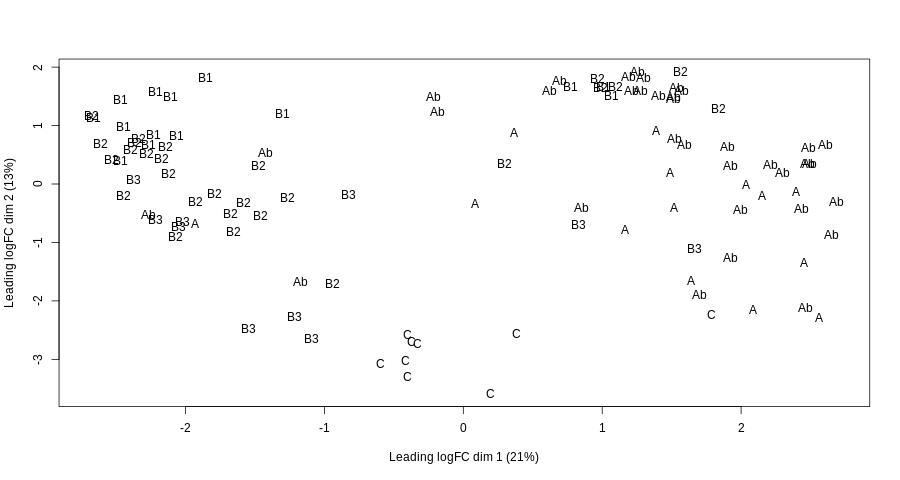

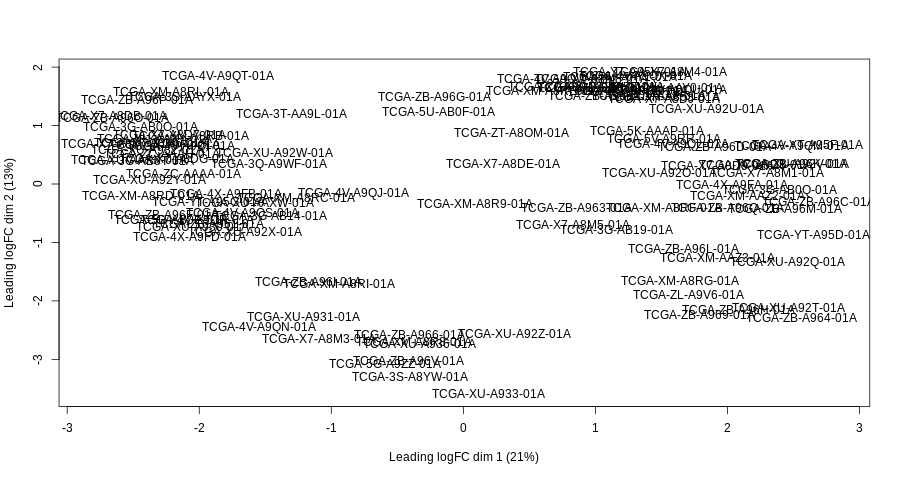

In [ ]:
%%R -w 900
plotMDS(de_exp_table, labels = ann$Histology)
plotMDS(de_exp_table)

Оцениваем дисперсию NB-распределения (нужно понять, что у нас с вариабельностью внутри групп)

In [ ]:
%%R
de_exp_table <- estimateDisp(de_exp_table, design)

На этом этапе оценивается парметр $\phi$ NB распределения. Метод оценки состоит из 3 этапов:
1. Оценка для каждого гена отдельно
2. Взятие среднего
3. Приведение значений для каждого гена ближе к среднему

(команду из предыдущей ячейке можно заменить на 3 последовательных)

Это нужно чтобы убрать существенные отличия в дисперсии между генами, которые могут возникать, например, из-за выбросов в данных.

Корень из $\phi$ называют "biological coefficient of variation" (BCV) или "dispersion"

$$BCV_g=\sqrt\phi_g$$


Оцениваем:
- дисперсию для каждолго гена
- common (усредненную по всем генам)
- trend (предсказанную)

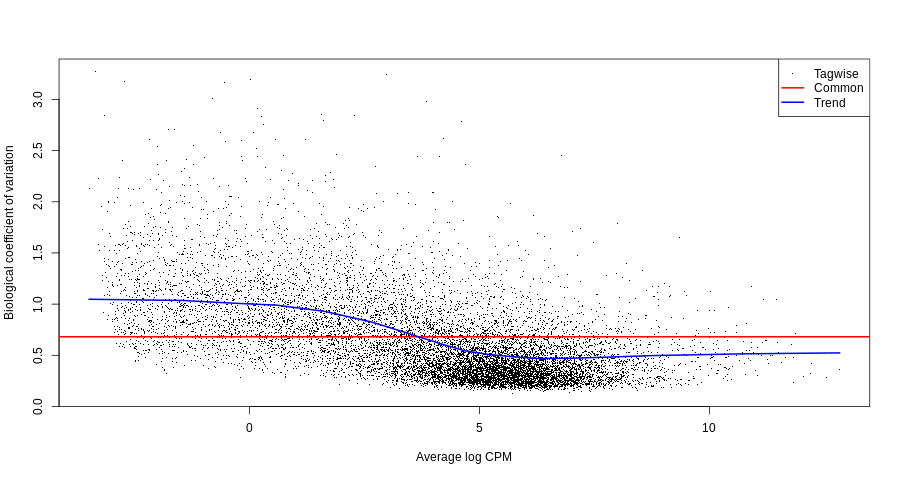

In [ ]:
%%R -w 900
plotBCV(de_exp_table)

если реплик мало, можно еще внести допущение, что гены с похожей средней экспрессией имеют похожую дисперсию. Здесь не обязательно

In [ ]:
%%R
names(de_exp_table)

 [1] "counts"             "samples"            "design"            
 [4] "common.dispersion"  "trended.dispersion" "tagwise.dispersion"
 [7] "AveLogCPM"          "trend.method"       "prior.df"          
[10] "prior.n"            "span"              


Оцениваем коэффициенты GLM:

In [ ]:
%%R
fit <- glmQLFit(de_exp_table, design, robust=TRUE)

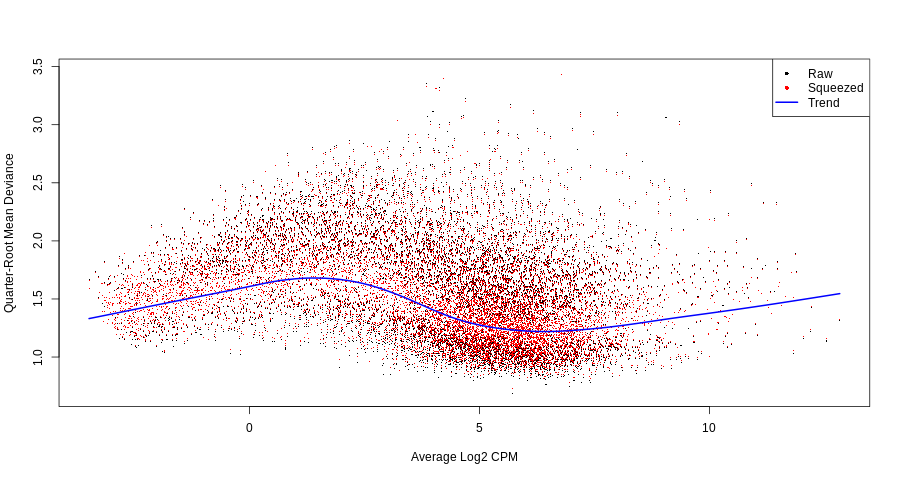

In [ ]:
%%R -w 900
plotQLDisp(fit)

In [ ]:
%%R
head(fit$coefficients)

      (Intercept) HistologyAb HistologyB1  HistologyA HistologyB2  HistologyC
TFAM    -9.842722  0.08697478   0.1328556  0.02440144  0.07626458  0.14261136
NCR3   -12.605767  0.13444089   0.4201994  0.01411884  0.37511342 -0.05788039
LRWD1   -9.651442 -0.66820335  -0.2929789 -0.68802021 -0.19348747 -0.60532746
APOL1   -8.711507 -0.43012166  -0.9498003 -0.29163247 -0.76944506 -0.37775450
NASP    -8.524270  0.28236508   0.6058327 -0.13223922  0.43246427 -0.22579187
PAM     -9.345962 -0.20421517  -1.1093053 -0.15556863 -0.71210876 -0.03936632


Делаем тест соотношения правдоподобий чтобы оценить значимость предикторов (если групп много, нужно использовать дополнительный аргумент coef, чтобы уточнить какой значимость какого коэффициента нужно посмотреть):

[1] 0

FALSE 
15520 
[1] 0

FALSE 
15520 
[1] 0

FALSE 
15520 
[1] 0

FALSE 
15520 
[1] 0

FALSE 
15520 


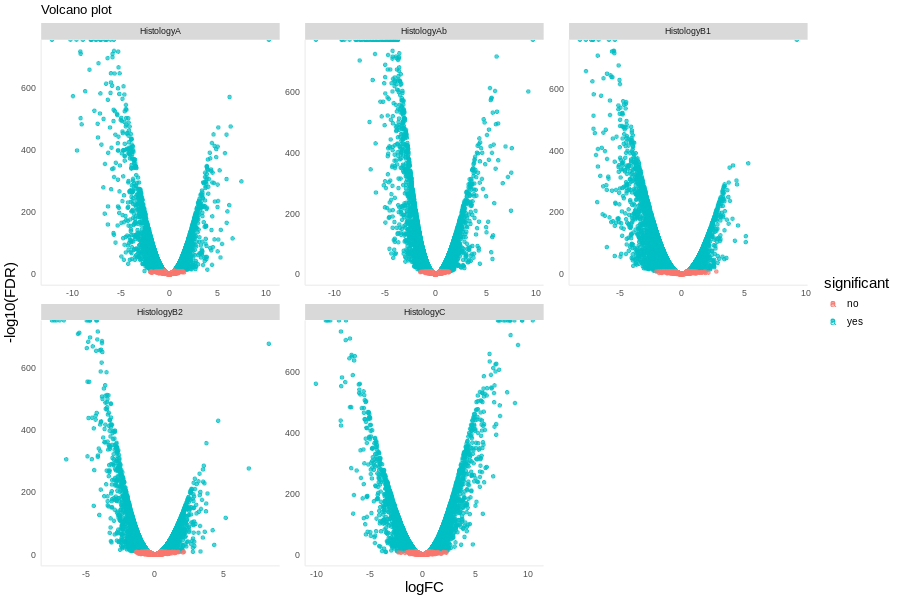

In [ ]:
%%R -w 900 -h 600
VOLCANO <- data.frame()
for (i in seq(2,ncol(fit),1)){
    lrt <- glmLRT(fit, coef=i)
    todraw <- as.data.frame(topTags(lrt, n=20000))
    colnames(todraw)[1] <- "value"
    todraw$significant <- "no"
    todraw$significant[todraw$FDR<0.0001] <- "yes"

    todraw$BEST <- "no"
    x <- quantile(todraw$FDR, 0.0005)
    x <- x[[1]][1]
    print(x)
    todraw$BEST[as.numeric(todraw$FDR)<x] <- "yes"
    print(table(as.numeric(todraw$FDR)<x))

    todraw$FDR <- -log(todraw$FDR)

    todraw$logFC <- colnames(fit)[i]
    todraw$Gene <- rownames(todraw)
    VOLCANO <- rbind(VOLCANO, todraw)
}

#print(head(VOLCANO))

ggplot(data=VOLCANO, aes(x=value, y=FDR, color=significant, group=logFC))+
    geom_point(alpha=0.7)+
    geom_text_repel(data=VOLCANO[VOLCANO$BEST=="yes",], aes(label=Gene))+ # use this carefully  & abs(value)>3
    facet_wrap(~logFC, scales="free")+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          #axis.text.x = element_blank(),
          #axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=15),
         axis.title.y = element_text(size=15),
         legend.text = element_text(size = 10), legend.title = element_text(size=15),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab("logFC")+
    ggtitle("Volcano plot")+
    ylab("-log10(FDR)")

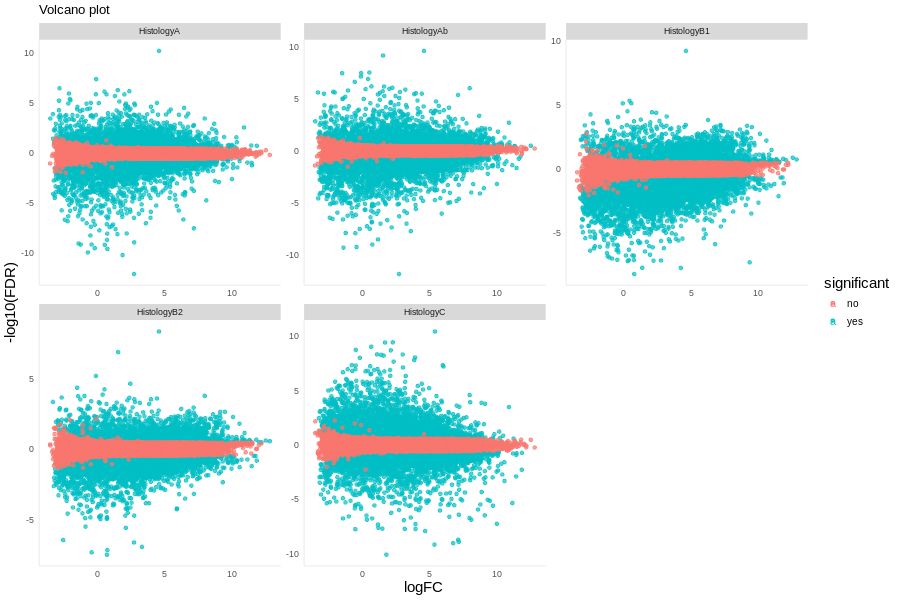

In [ ]:
%%R -w 900 -h 600
ggplot(data=VOLCANO, aes(x=logCPM, y=value, color=significant, group=logFC))+
    geom_point(alpha=0.7)+
    geom_text_repel(data=VOLCANO[VOLCANO$BEST=="yes",], aes(label=Gene))+ # use this carefully  & abs(value)>3
    facet_wrap(~logFC, scales="free")+
    theme(panel.background = element_rect(fill = "white", colour = NA),
         panel.grid.major = element_line(colour = "white"),
          #axis.text.x = element_blank(),
          #axis.text.y = element_blank(),
         axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.line.x = element_line(color="grey92"),
         axis.line.y = element_line(color="grey92"),
         axis.title.x = element_text(size=15),
         axis.title.y = element_text(size=15),
         legend.text = element_text(size = 10), legend.title = element_text(size=15),
         legend.key = element_rect(fill = "white", color = NA))+
    xlab("logFC")+
    ggtitle("Volcano plot")+
    ylab("-log10(FDR)")

Экспортируем результат в Python (номер коэффициента берется из объекта fit, возьмем наличие карциномы тимуса):

In [ ]:
%%R
colnames(fit)

[1] "(Intercept)" "HistologyAb" "HistologyB1" "HistologyA"  "HistologyB2"
[6] "HistologyC" 


Экспортируем результат для Thymic carcinoma VS Ab

In [ ]:
%%R
lrt <- glmLRT(fit, coef=6)
edger_res <- as.data.frame(topTags(lrt, n=20000))

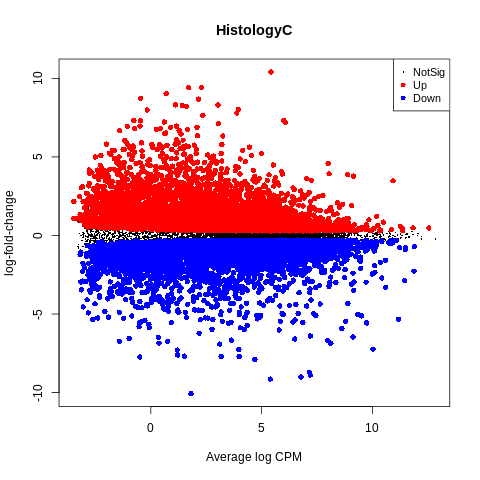

In [ ]:
%%R
plotMD(lrt)

In [ ]:
%R -o edger_res

In [ ]:
edger_res

logFC    logCPM            LR    PValue       FDR
MYBPC1   10.412395  5.423702  2.493677e+03  0.000000  0.000000
SOX14     9.416648  2.287424  1.785477e+03  0.000000  0.000000
IGF2BP3   9.398598  1.714081  1.685514e+03  0.000000  0.000000
NEFM     -9.141743  5.386357  1.827864e+03  0.000000  0.000000
SFTPC    -9.013570  6.775387  1.508244e+03  0.000000  0.000000
...            ...       ...           ...       ...       ...
GLTP     -0.000171  5.924042  1.561571e-06  0.999003  0.999260
PLCD3     0.000135  3.967054  9.615171e-07  0.999218  0.999411
ZFYVE16  -0.000110  4.531820  6.421290e-07  0.999361  0.999489
HIPK4    -0.000793 -2.422464  1.563500e-07  0.999685  0.999749
SNX11    -0.000039  5.051101  8.163661e-08  0.999772  0.999772

[15520 rows x 5 columns]

In [ ]:
edger_res = edger_res.sort_values(by = 'logFC', ascending = False)[edger_res['FDR'] < 0.01]

In [ ]:
edger_res

logFC    logCPM           LR         PValue            FDR
MYBPC1   10.412395  5.423702  2493.676910   0.000000e+00   0.000000e+00
SOX14     9.416648  2.287424  1785.477369   0.000000e+00   0.000000e+00
IGF2BP3   9.398598  1.714081  1685.514123   0.000000e+00   0.000000e+00
BARX1     9.019197  0.691325  1383.678371  7.398924e-303  4.784637e-300
SOST      8.730539 -0.464733  1000.110526  1.699188e-219  3.563703e-217
...            ...       ...          ...            ...            ...
PSMB11   -8.702009  7.150450  1843.928800   0.000000e+00   0.000000e+00
NEFL     -8.888460  7.190608  1927.457312   0.000000e+00   0.000000e+00
SFTPC    -9.013570  6.775387  1508.244261   0.000000e+00   0.000000e+00
NEFM     -9.141743  5.386357  1827.864177   0.000000e+00   0.000000e+00
CFC1    -10.069332  1.812059  1128.128133  2.543696e-247  9.399562e-245

[9004 rows x 5 columns]

### one comparison

In [ ]:
#for tpm C and B1 only
ann_sel = ann[(ann['Histology'] == 'C') | (ann['Histology'] == 'B3')]
expr_sel = expr[ann_sel.index]

In [ ]:
%%R -i ann_sel
ann_sel$Histology <- factor(ann_sel$Histology, levels=c('B3','C'))
ann_sel$Histology <- relevel(ann_sel$Histology, ref="B3")
print(ann_sel$Histology)

 [1] C  C  C  C  C  B3 B3 B3 B3 B3 C  C  B3 B3 C  B3 C  B3 B3
Levels: B3 C


In [ ]:
%%R
design <- model.matrix(~Histology, data=ann_sel) #+Time
head(design)

                 (Intercept) HistologyC
TCGA-XU-A92Z-01A           1          1
TCGA-ZB-A969-01A           1          1
TCGA-ZB-A96V-01A           1          1
TCGA-XU-A933-01A           1          1
TCGA-3S-A8YW-01A           1          1
TCGA-4V-A9QN-01A           1          0


In [ ]:
%%R -i expr_sel
de_exp_table <- DGEList(expr_sel, group = ann_sel$Histology)
dim(design)

[1] 19  2


In [ ]:
%%R
keep <- filterByExpr(de_exp_table, design)
de_exp_table <- de_exp_table[keep, keep.lib.sizes=FALSE]
dim(de_exp_table)

[1] 14459    19


In [ ]:
%%R
de_exp_table <- calcNormFactors(de_exp_table)

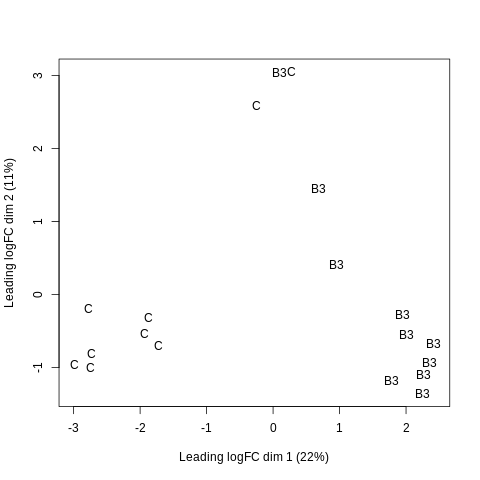

In [ ]:
%%R
plotMDS(de_exp_table, labels = ann_sel$Histology)

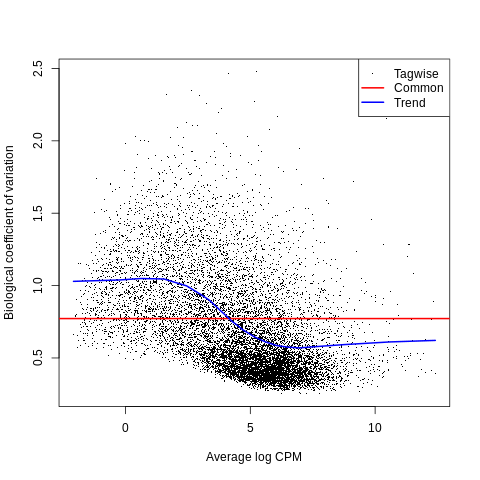

In [ ]:
%%R
de_exp_table <- estimateDisp(de_exp_table, design, robust=TRUE)
plotBCV(de_exp_table)

In [ ]:
%%R
fit <- glmFit(de_exp_table, design)
lrt <- glmLRT(fit)
topTags(lrt)

Coefficient:  HistologyC 
              logFC   logCPM       LR       PValue          FDR
KIAA1549L  8.307302 5.254277 91.67020 1.023954e-21 1.480535e-17
PSMB11    -8.787545 6.858273 74.78397 5.251425e-18 3.796518e-14
RAB27B     3.866957 4.524822 70.11400 5.597428e-17 2.697773e-13
CREB3L1    5.394467 5.417156 61.05225 5.558009e-15 2.009081e-11
FGD5       4.126675 6.263514 58.95914 1.609801e-14 4.655222e-11
NPTX1     -6.855768 8.247602 56.12595 6.797401e-14 1.606942e-10
CLEC1A    -5.030810 6.128213 55.86059 7.779648e-14 1.606942e-10
COX7A1    -4.954863 6.984697 55.35022 1.008585e-13 1.822891e-10
SULF1      3.487209 6.620961 53.63084 2.419311e-13 3.886757e-10
CCL20      7.870001 6.322489 53.22530 2.974043e-13 4.300169e-10


In [ ]:
%%R
colnames(design)

[1] "(Intercept)" "HistologyC" 


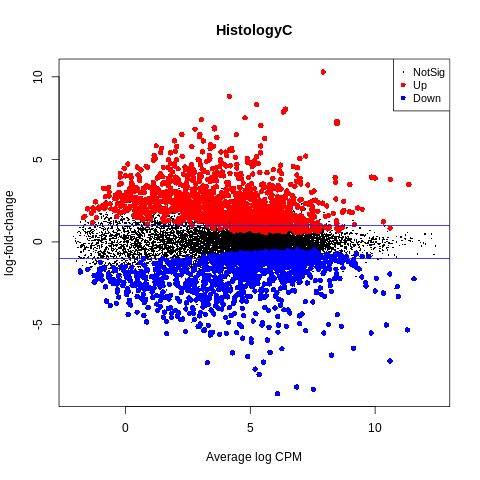

In [ ]:
%%R
plotMD(lrt)
abline(h=c(-1, 1), col="blue")

## DESeq2

In [ ]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B3")
condition <- ann$Histology

In [ ]:
%%R -i expr
pats <- rownames(ann)#colnames(expr_matrix)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
print(dds)

class: DESeqDataSet 
dim: 17752 109 
metadata(1): version
assays(1): counts
rownames(17752): TFAM NCR3 ... ETV6 SLC15A2
rowData names(0):
colnames(109): TCGA-XM-A8RB-01A TCGA-ZB-A96F-01A ... TCGA-XM-A8R9-01A
  TCGA-X7-A8M1-01A
colData names(1): condition


In [ ]:
%%R
dds <- DESeq(dds)
print(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





class: DESeqDataSet 
dim: 17752 109 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(17752): TFAM NCR3 ... ETV6 SLC15A2
rowData names(39): baseMean baseVar ... maxCooks replace
colnames(109): TCGA-XM-A8RB-01A TCGA-ZB-A96F-01A ... TCGA-XM-A8R9-01A
  TCGA-X7-A8M1-01A
colData names(3): condition sizeFactor replaceable


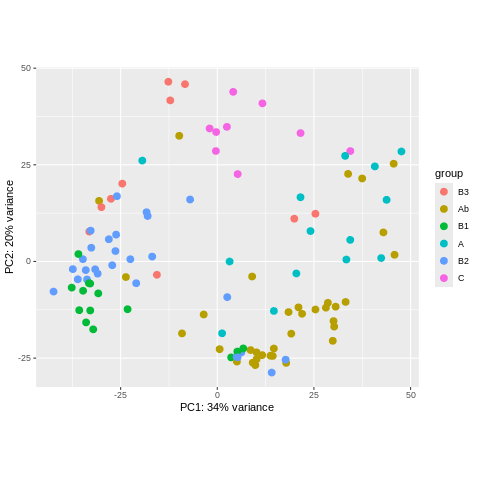

In [ ]:
%%R

vsdata = vst(dds, blind = FALSE)
plotPCA(vsdata, intgroup = 'condition')

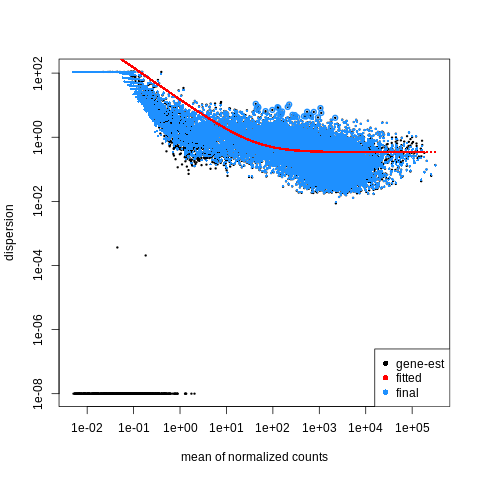

<rpy2.robjects.vectors.ListVector object at 0x7929f08afe00> [RTYPES.VECSXP]
R classes: ('list',)
[ListSexpVector, ListSexpVector]
  rect: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7929f06794c0> [RTYPES.VECSXP]
  text: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x7929f0655f00> [RTYPES.VECSXP]

In [ ]:
%R plotDispEsts(dds)

In [ ]:
%%R -o deseq_res
res <- results(dds, contrast = c("condition", 'C', 'B3'))
deseq_res <- as.data.frame(res)
head(res)

log2 fold change (MLE): condition C vs B3 
Wald test p-value: condition C vs B3 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat      pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric>   <numeric> <numeric>
TFAM    2.48262e+03     0.21822648  0.141038  1.5472930 0.121792621 0.2449236
NCR3    1.80584e+02    -0.00580184  0.518499 -0.0111897 0.991072114 0.9986791
LRWD1   1.84679e+03    -0.85403481  0.251275 -3.3988086 0.000676801 0.0042797
APOL1   4.42470e+03    -0.53693371  0.316349 -1.6972802 0.089643702 0.1959958
FOXD4L3 2.12768e+00    -0.19427077  0.822478 -0.2362017 0.813276174 0.9022913
GDF2    1.76686e-02     0.28742211  6.983074  0.0411598 0.967168480        NA


In [ ]:
deseq_res

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TFAM     2482.620539        0.218226  0.141038  1.547293  0.121793  0.244924
NCR3      180.583981       -0.005802  0.518499 -0.011190  0.991072  0.998679
LRWD1    1846.789253       -0.854035  0.251275 -3.398809  0.000677  0.004280
APOL1    4424.698232       -0.536934  0.316349 -1.697280  0.089644  0.195996
FOXD4L3     2.127679       -0.194271  0.822478 -0.236202  0.813276  0.902291
...              ...             ...       ...       ...       ...       ...
NAT8        5.271353       -2.856101  0.900660 -3.171120  0.001519  0.008270
GPR68     313.607086        0.054377  0.404333  0.134485  0.893019  0.949528
NDUFS1   3596.043618        0.143114  0.113244  1.263766  0.206314  0.359394
ETV6     4309.099717        0.851845  0.184804  4.609460  0.000004  0.000061
SLC15A2   273.903623        0.845502  0.340288  2.484665  0.012967  0.045607

[17752 rows x 6 columns]

In [ ]:
deseq_res = deseq_res.sort_values(by = 'log2FoldChange', ascending = False)[deseq_res['padj']< 0.01]
deseq_res

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
MYBPC1   1864.730093       10.328908  0.927451  11.136875  8.298048e-29   
IGF2BP3   140.930720        9.658944  0.689890  14.000705  1.543323e-44   
LBX1       39.643835        9.554854  1.712337   5.580007  2.405083e-08   
SOX14     208.706853        9.162113  1.979487   4.628528  3.682738e-06   
NEUROG2    15.481781        8.982190  1.480477   6.067092  1.302471e-09   
...              ...             ...       ...        ...           ...   
PSMB11   6115.048516       -8.790501  0.689068 -12.757086  2.846530e-37   
NEFL     6219.818253       -8.908805  1.231121  -7.236336  4.609679e-13   
SALL3      21.810127       -9.039222  1.661970  -5.438859  5.362302e-08   
NEFM     1770.829739       -9.176830  1.238470  -7.409814  1.264769e-13   
CFC1      148.280851      -10.609055  1.279685  -8.290365  1.129018e-16   

                 padj  
MYBPC1   2.039186e-25  
IGF2BP3  2.654823e-40  
LBX1     7.910563e-07  
SOX14    5.616176e-05  
NEUROG2  6.293568e-08  
...               ...  
PSMB11   1.632200e-33  
NEFL     5.394265e-11  
SALL3    1.558147e-06  
NEFM     1.648224e-11  
CFC1     3.291758e-14  

[3311 rows x 6 columns]

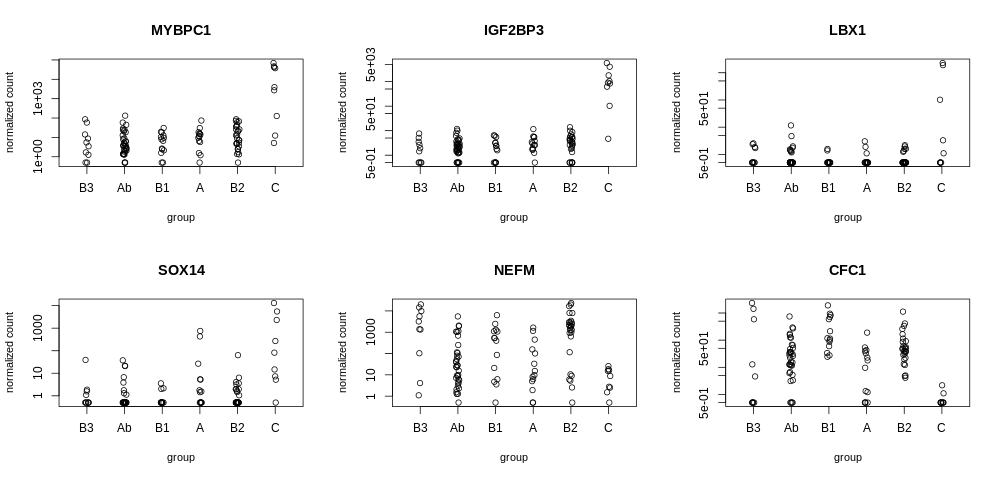

In [ ]:
%%R -w 1000
#Задаём размер текста и композицию графика
par(mfrow=c(2,3), cex=1.0, cex.main=1.2, cex.axis=1, cex.lab=0.9)

plotCounts(dds, gene="MYBPC1", intgroup="condition")
plotCounts(dds, gene="IGF2BP3", intgroup="condition")
plotCounts(dds, gene="LBX1", intgroup="condition")
plotCounts(dds, gene="SOX14", intgroup="condition")
plotCounts(dds, gene="NEFM", intgroup="condition") # down
plotCounts(dds, gene="CFC1", intgroup="condition") #down

In [ ]:
%%R
head(res)

log2 fold change (MLE): condition C vs B3 
Wald test p-value: condition C vs B3 
DataFrame with 6 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat      pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric>   <numeric> <numeric>
TFAM    2.48262e+03     0.21822648  0.141038  1.5472930 0.121792621 0.2449236
NCR3    1.80584e+02    -0.00580184  0.518499 -0.0111897 0.991072114 0.9986791
LRWD1   1.84679e+03    -0.85403481  0.251275 -3.3988086 0.000676801 0.0042797
APOL1   4.42470e+03    -0.53693371  0.316349 -1.6972802 0.089643702 0.1959958
FOXD4L3 2.12768e+00    -0.19427077  0.822478 -0.2362017 0.813276174 0.9022913
GDF2    1.76686e-02     0.28742211  6.983074  0.0411598 0.967168480        NA


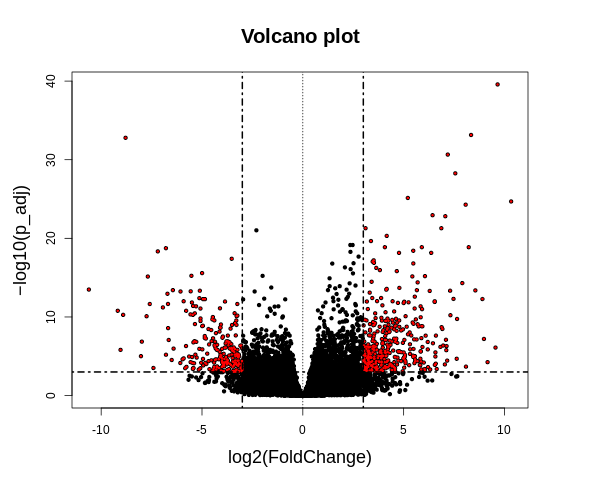

In [ ]:
%%R -w 600

#Задаём размер текста и композицию графика
par(mar=c(5,5,5,5), cex=1.0, cex.main=1.7, cex.axis=1, cex.lab=1.5)

#Отрисовываем все точки чёрным цветом
with(res, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab="log2(FoldChange)", ylab="−log10(p_adj)"))

#Отрисовываем точки, прошедшие порог, красным цветом
with(subset(res, padj<0.001 & abs(log2FoldChange)>3), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))

#Отрисовываем линии с порогами
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-3, col="black", lty=4, lwd=2.0)
abline(v=3, col="black", lty=4, lwd=2.0)
abline(h=3, col="black", lty=4, lwd=2.0)

In [ ]:
deseq_res.shape

(3311, 6)

# Determine intersected genes between tools

In [ ]:
edger_res.head()

logFC    logCPM           LR         PValue            FDR
MYBPC1   10.412395  5.423702  2493.676910   0.000000e+00   0.000000e+00
SOX14     9.416648  2.287424  1785.477369   0.000000e+00   0.000000e+00
IGF2BP3   9.398598  1.714081  1685.514123   0.000000e+00   0.000000e+00
BARX1     9.019197  0.691325  1383.678371  7.398924e-303  4.784637e-300
SOST      8.730539 -0.464733  1000.110526  1.699188e-219  3.563703e-217

In [ ]:
deseq_res

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
MYBPC1   1864.730093       10.328908  0.927451  11.136875  8.298048e-29   
IGF2BP3   140.930720        9.658944  0.689890  14.000705  1.543323e-44   
LBX1       39.643835        9.554854  1.712337   5.580007  2.405083e-08   
SOX14     208.706853        9.162113  1.979487   4.628528  3.682738e-06   
NEUROG2    15.481781        8.982190  1.480477   6.067092  1.302471e-09   
...              ...             ...       ...        ...           ...   
PSMB11   6115.048516       -8.790501  0.689068 -12.757086  2.846530e-37   
NEFL     6219.818253       -8.908805  1.231121  -7.236336  4.609679e-13   
SALL3      21.810127       -9.039222  1.661970  -5.438859  5.362302e-08   
NEFM     1770.829739       -9.176830  1.238470  -7.409814  1.264769e-13   
CFC1      148.280851      -10.609055  1.279685  -8.290365  1.129018e-16   

                 padj  
MYBPC1   2.039186e-25  
IGF2BP3  2.654823e-40  
LBX1     7.910563e-07  
SOX14    5.616176e-05  
NEUROG2  6.293568e-08  
...               ...  
PSMB11   1.632200e-33  
NEFL     5.394265e-11  
SALL3    1.558147e-06  
NEFM     1.648224e-11  
CFC1     3.291758e-14  

[3311 rows x 6 columns]

In [ ]:
edger_top = edger_res[edger_res['logFC'] > 0].index
edger_down = edger_res[edger_res['logFC'] < 0].index

deseq_top = deseq_res[deseq_res['log2FoldChange'] > 0].index
deseq_down = deseq_res[deseq_res['log2FoldChange'] < 0].index

In [ ]:
top_genes = set(edger_top) & set(deseq_top)
len(top_genes)

down_genes = set(edger_down) & set(deseq_down)
len(top_genes)

1768

In [ ]:
len(deseq_top)

1860

In [ ]:
from matplotlib_venn import venn2

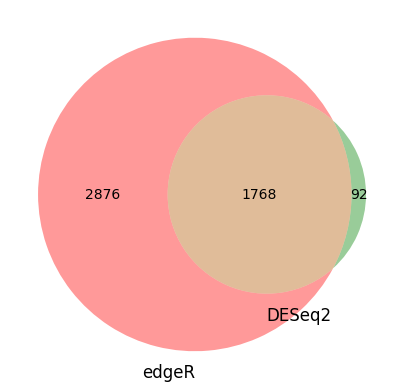

In [ ]:
venn2(subsets = (len(edger_top) - len(top_genes), len(deseq_top) - len(top_genes),len(top_genes)),
     set_labels = ('edgeR', 'DESeq2'))

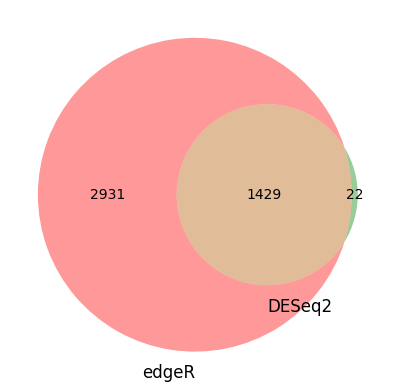

In [ ]:
venn2(subsets = (len(edger_down) - len(down_genes), len(deseq_down) - len(down_genes),len(down_genes)),
     set_labels = ('edgeR', 'DESeq2'))

In [ ]:
len(edger_down)

4360

In [ ]:
len(deseq_down)

1451

# GO

Очень часто после нахождения дифференциально экспрессированных генов делают gene set enrichment analysis (GSEA), чтобы оценить, какие пути сигнальные меняют свою активность в сравнивемых группах.
Для этого есть разные пакеты, здесь используется пакет питоновский gseapy (однако если есть любовь к R, есть gseapy в Bioconductor). На вход нужно подать набор генсетов в формате gmt и дифференциально экспрессированные гены.

идем в mSIGdb http://www.gsea-msigdb.org/gsea/msigdb и в GSEAPY https://gseapy.readthedocs.io/en/latest/introduction.html

In [ ]:
!pip install gseapy
import gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 24.4 MB/s eta 0:00:00


In [ ]:
names = gseapy.get_library_name(organism='Human')

In [ ]:
names[:20]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020']

In [ ]:
gene_sets=['Panther_2016','GO_Biological_Process_2021']

In [343]:
len(top_genes)

1768

In [344]:
gene_sets

['Panther_2016', 'GO_Biological_Process_2021']

In [ ]:
enr_top = gseapy.enrichr(gene_list=list(top_genes),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

In [ ]:
enr_top.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term  Overlap       P-value  \
0   cytokine-mediated signaling pathway (GO:0019221)  122/621  1.661616e-17   
1     extracellular matrix organization (GO:0030198)   71/300  8.130652e-15   
2                 inflammatory response (GO:0006954)   59/230  3.613301e-14   
3  cellular response to cytokine stimulus (GO:007...   94/482  1.480142e-13   
4  regulation of cell population proliferation (G...  128/764  7.796929e-13   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.856123e-14            0                     0    2.633975   
1      1.922086e-11            0                     0    3.289167   
2      5.694562e-11            0                     0    3.646327   
3      1.749527e-10            0                     0    2.582456   
4      7.372776e-10            0                     0    2.159350   

   Combined Score                                              Genes  
0      101.766673  CD86;CSF3;CD80;IL5RA;CXCL13;FGF2;ICAM1;IL27RA;...  
1      106.710885  VIT;COLGALT2;SPARC;ECM2;ITGAM;COL14A1;ITGB4;IT...  
2      112.859548  CIITA;CXCL9;CXCL8;TNFAIP6;CXCL1;CXCL13;CXCL3;C...  
3       76.289535  CD86;CSF3;ITGAM;CXCL8;CD80;IL5RA;CXCL1;FGF2;CX...  
4       60.202400  CD86;CSF3;TFRC;FGF1;FGF2;IGF1R;FGF5;FGF7;ZNF60...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

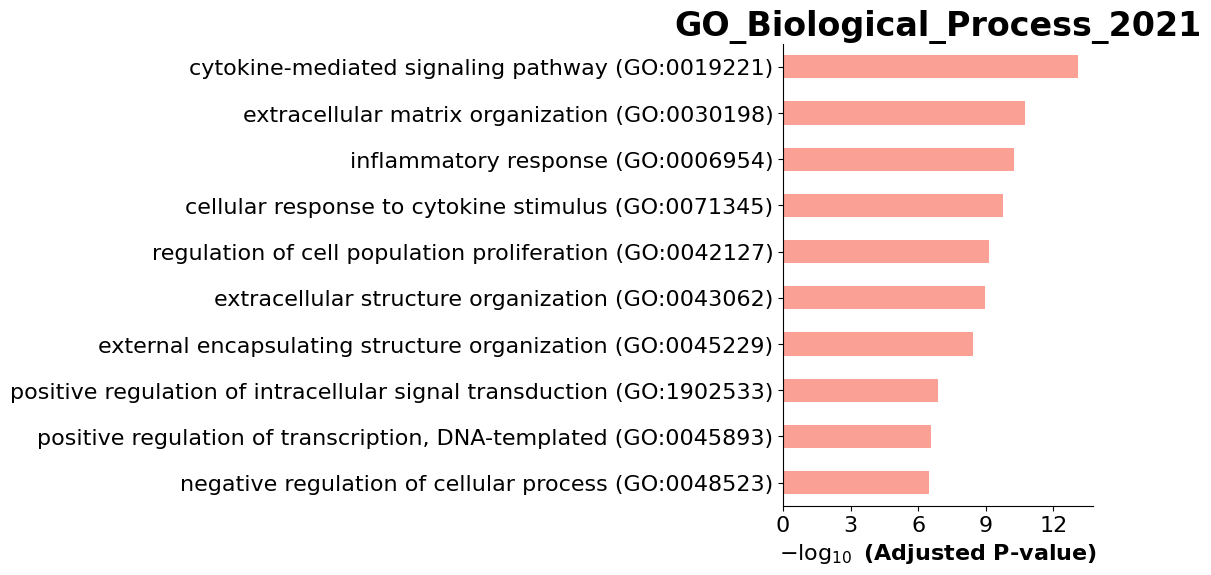

In [ ]:
from gseapy.plot import barplot, dotplot

barplot(enr_top.res2d,title=gene_sets[1])#'GO_Biological_Process_2021')

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

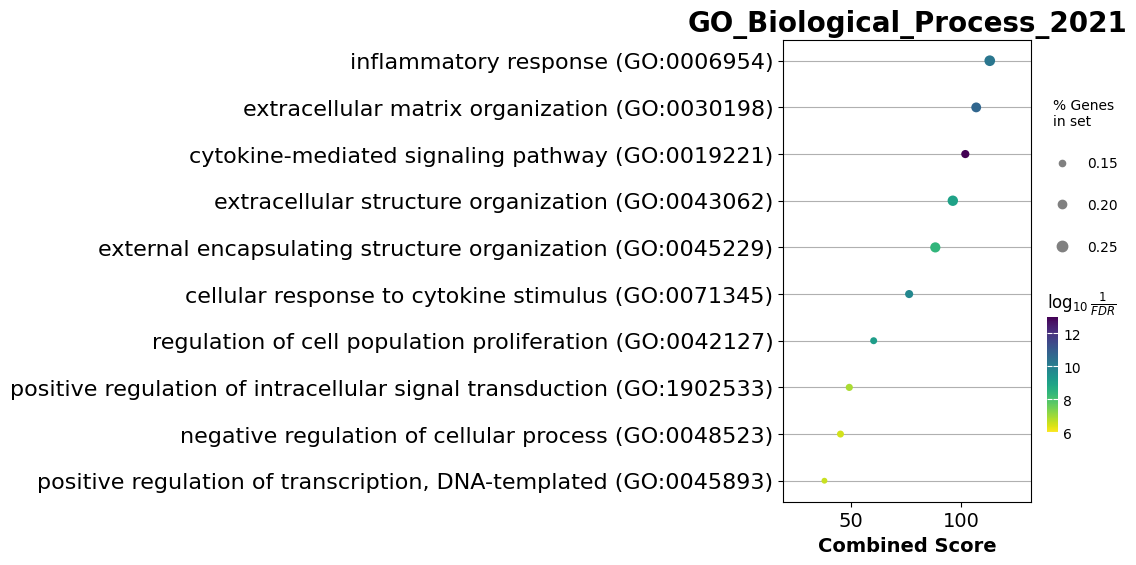

In [ ]:
dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

In [ ]:
enr_down = gseapy.enrichr(gene_list=list(down_genes),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

In [ ]:
enr_down.results.head(5)

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0  mitochondrial respiratory chain complex assemb...   21/90  0.000001   
1      aerobic electron transport chain (GO:0019646)   18/70  0.000001   
2  mitochondrial electron transport, NADH to ubiq...   13/39  0.000002   
3  mitochondrial ATP synthesis coupled electron t...   18/71  0.000002   
4  antigen processing and presentation of lipid a...     5/5  0.000002   

   Adjusted P-value  Old P-value  Old Adjusted P-value    Odds Ratio  \
0          0.000812            0                     0      3.999321   
1          0.000812            0                     0      4.543177   
2          0.000812            0                     0      6.548376   
3          0.000812            0                     0      4.457216   
4          0.000812            0                     0  92855.000000   

   Combined Score                                              Genes  
0    5.500400e+01  NDUFA8;NDUFA6;TIMMDC1;COX16;NDUFB6;NDUFA5;NDUF...  
1    6.132610e+01  NDUFA8;NDUFA6;NDUFB6;NDUFA5;NDUFB5;NDUFA4;COX4...  
2    8.708280e+01  NDUFA8;NDUFA6;NDUFB6;NDUFA5;NDUFB5;NDUFA4;NDUF...  
3    5.916794e+01  NDUFA8;NDUFA6;NDUFB6;NDUFA5;NDUFB5;NDUFA4;COX4...  
4    1.225721e+06                           CD1E;CD1D;CD1C;CD1B;CD1A

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

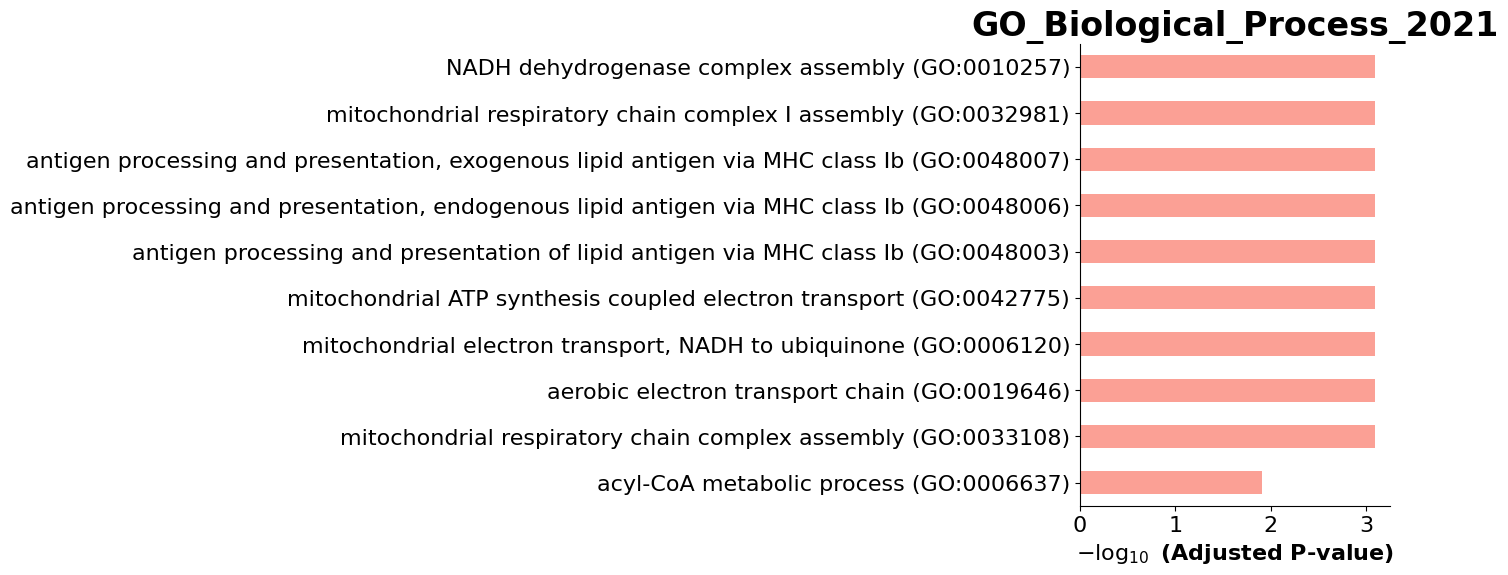

In [ ]:
from gseapy.plot import barplot, dotplot

barplot(enr_down.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

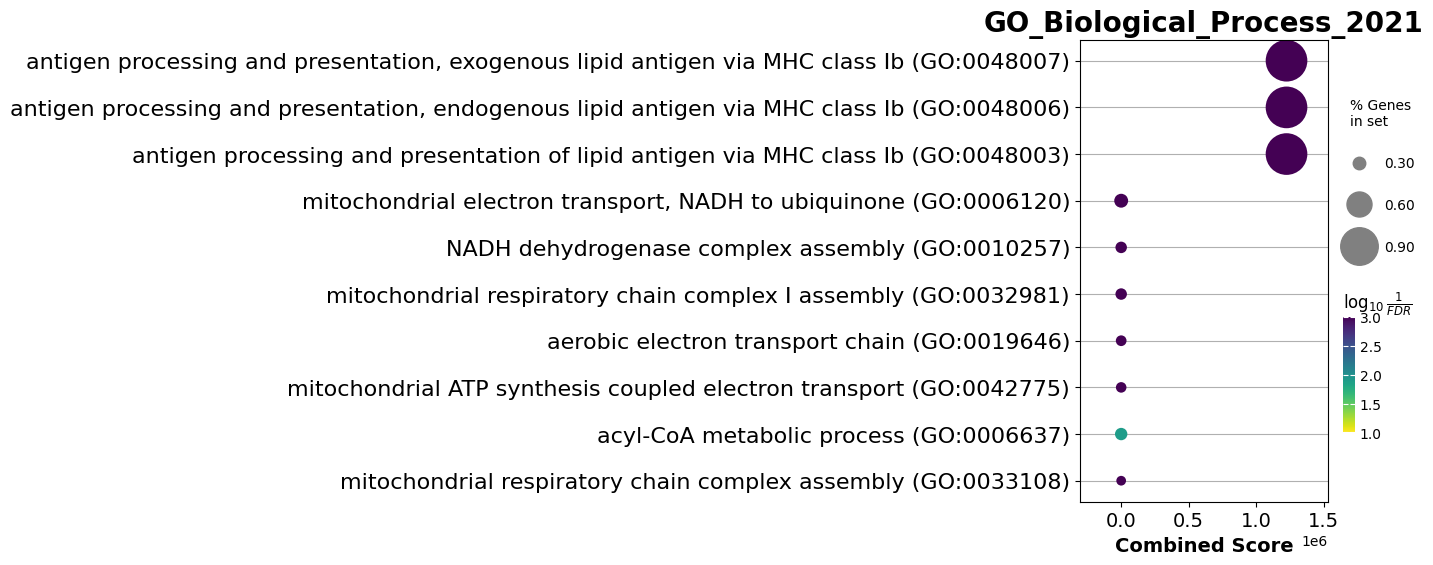

In [ ]:
dotplot(enr_down.res2d, title=gene_sets[1],cmap='viridis_r')

# ssGSEA

In [ ]:
%%R
ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
    row_names = rownames(X)
    num_genes = nrow(X)
    gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})

    # Ranks for genes
    R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')

    # Calculate enrichment score (es) for each sample (column)
    es = apply(R, 2, function(R_col) {
        gene_ranks = order(R_col, decreasing = TRUE)

        # Calc es for each gene set
        es_sample = sapply(gene_sets, function(gene_set_idx) {
            # pos: match (within the gene set)
            # neg: non-match (outside the gene set)
            indicator_pos = gene_ranks %in% gene_set_idx
            indicator_neg = !indicator_pos

            rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha

            step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
            step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)

            step_cdf_diff = step_cdf_pos - step_cdf_neg

            # Normalize by gene number
            if (scale) step_cdf_diff = step_cdf_diff / num_genes

            # Use ssGSEA or not
            if (single) {
                sum(step_cdf_diff)
            } else {
                step_cdf_diff[which.max(abs(step_cdf_diff))]
            }
        })
        unlist(es_sample)
    })

    if (length(gene_sets) == 1) es = matrix(es, nrow = 1)

    # Normalize by absolute diff between max and min
    if (norm) es = es / diff(range(es))

    # Prepare output
    rownames(es) = names(gene_sets)
    colnames(es) = colnames(X)
    return(es)
}

In [ ]:
log2_expr = np.log2(expr_tpm + 1)

In [ ]:
go_bp = gseapy.get_library(name='GO_Biological_Process_2021', organism='Human')
print(go_bp['glycoprotein catabolic process (GO:0006516)'])

['MANBA', 'EDEM1', 'EDEM2', 'FBXO17', 'NGLY1', 'FBXO2', 'FBXO27', 'OGA', 'FBXO44', 'ADAMTS12', 'NCCRP1', 'MMP12', 'NEU4', 'CTSL', 'NEU2', 'STT3B', 'FBXO6', 'ADAMTS9']


In [ ]:
gene_set = pd.DataFrame(go_bp['response to type I interferon (GO:0034340)'])
gene_set.columns = ['response to type I interferon (GO:0034340)']

In [ ]:
%%R -i gene_set
gene_set

  response to type I interferon (GO:0034340)
0                                        MX1
1                                      SP100
2                                      SHMT2
3                                      SMPD1
4                                      ISG15
5                                       SHFL
6                                      IFIT1
7                                      SETD2
8                                     TRIM56


In [ ]:
%%R -i gene_set
gene_sets = as.list(as.data.frame(gene_set))

In [ ]:
%%R
gene_sets

$`response to type I interferon (GO:0034340)`
[1] "MX1"    "SP100"  "SHMT2"  "SMPD1"  "ISG15"  "SHFL"   "IFIT1"  "SETD2" 
[9] "TRIM56"



In [ ]:
%%R -i log2_expr

res <- ssgsea(as.matrix(log2_expr), gene_sets, scale = TRUE, norm = FALSE)
res1 = t(res)
head(res1)

                 response to type I interferon (GO:0034340)
TCGA-XM-A8RB-01A                                  0.2697092
TCGA-ZB-A96F-01A                                  0.3159319
TCGA-ZC-AAAA-01A                                  0.2663227
TCGA-ZB-A96P-01A                                  0.2911733
TCGA-ZC-AAAF-01A                                  0.2621899
TCGA-XM-A8RC-01A                                  0.2372878


In [ ]:
%%R
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]

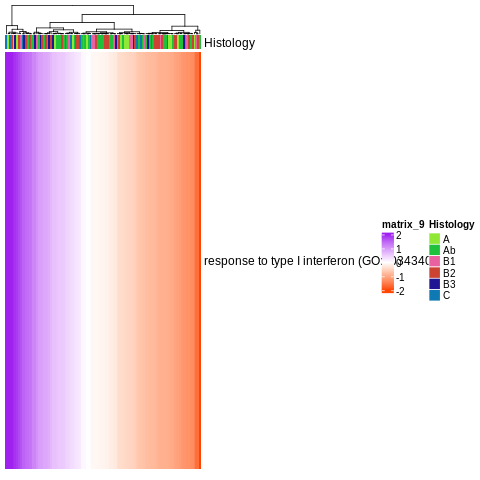

In [ ]:
%%R -i ann
df = as.data.frame(ann$Histology)
colnames(df) = "Histology"
ha = HeatmapAnnotation(df = df)

Heatmap(mat, top_annotation = ha, col = colorRamp2(c(-2,0,2), c("orangered", "white", "purple")),
        column_names_gp = gpar(fontsize = 0))

Задача: найти процессы, позволяющие объяснить разделение пациентов на гистологические типы

**Задача**: изучите гены, которые являются дифференциально экспрессированными в каждом из гистологических типов. Какие процессы в них различаются? Есть ли этому какое-то объяснение в статьях?

# Возьмем в качестве референса каждый гист тип по очереди и посчитаем все дифф экспрессии, после чего для каждого гистологического типа возьмем множество пересекающихся генов в диффэкспрессии относительно референсов и получим конечную таблицу

In [243]:
%%R$
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B3")
condition <- ann$Histology

In [245]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)

In [246]:
%%R
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





class: DESeqDataSet 
dim: 17752 109 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(17752): AURKAIP1 ABHD4 ... SUSD3 KRTAP5-11
rowData names(39): baseMean baseVar ... maxCooks replace
colnames(109): TCGA-ZB-A96L-01A TCGA-3G-AB0O-01A ... TCGA-3G-AB0Q-01A
  TCGA-YT-A95H-01A
colData names(3): condition sizeFactor replaceable


In [247]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "B3"  # "B3" как контрольная группа

opposite_B3 <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_B3[[hist_type]] <- res
    }
}

In [251]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B2")
condition <- ann$Histology

In [252]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





In [253]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "B2"  # "B2" как контрольная группа

opposite_B2 <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_B2[[hist_type]] <- res
    }
}

In [254]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="B1")
condition <- ann$Histology

In [255]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





In [256]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "B1"  # "B1$" как контрольная группа

opposite_B1 <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_B1[[hist_type]] <- res
    }
}

In [257]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="Ab")
condition <- ann$Histology

In [258]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





In [259]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "Ab"  # "Ab" как контрольная группа

opposite_Ab <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_Ab[[hist_type]] <- res
    }
}

In [260]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="A")
condition <- ann$Histology

In [261]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





In [262]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "A"  # "A" как контрольная группа

opposite_A <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_A[[hist_type]] <- res
    }
}

In [263]:
%%R
ann$Histology <- factor(ann$Histology, levels=c('Ab', 'B1', 'A', 'B2', 'B3', 'C'))
ann$Histology <- relevel(ann$Histology, ref="C")
condition <- ann$Histology

In [264]:
%%R -i expr
pats <- rownames(ann)
colData <- data.frame(condition, row.names = pats)
dds <- DESeqDataSetFromMatrix(expr, colData, design=~condition)
dds <- DESeq(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





In [265]:
%%R
histology_types <- levels(ann$Histology)  # Получаем все типы
control_group <- "C"  # "C" как контрольная группа

opposite_C <- list()  # Список для хранения топ генов

for (hist_type in histology_types) {
    # Пропускаем анализ для "B3", так как это контрольная группа
    if (hist_type != control_group) {
        res <- results(dds, contrast = c("condition", hist_type, control_group))

        res <- res[order(res$padj, na.last=NA), ]  # Сортируем по значимости (padj)
        res <- res[res$padj < 0.05, ]  # Оставляем значимые гены

        opposite_C[[hist_type]] <- res
    }
}

In [288]:
%%R -o deg_A_C
deg_A_C = as.data.frame(opposite_C$A)

In [289]:
%%R -o deg_A_B1
deg_A_B1 = as.data.frame(opposite_B1$A)

In [290]:
%%R -o deg_A_B2
deg_A_B2 = as.data.frame(opposite_B2$A)

In [291]:
%%R -o deg_A_B3
deg_A_B3 = as.data.frame(opposite_B3$A)

In [292]:
%%R -o deg_A_Ab
deg_A_Ab = as.data.frame(opposite_Ab$A)

In [293]:
%%R -o deg_Ab_A
deg_Ab_A = as.data.frame(opposite_A$Ab)

In [294]:
%%R -o deg_Ab_B1
deg_Ab_B1 = as.data.frame(opposite_B1$Ab)

In [295]:
%%R -o deg_Ab_B2
deg_Ab_B2 = as.data.frame(opposite_B2$Ab)

In [296]:
%%R -o deg_Ab_B3
deg_Ab_B3 = as.data.frame(opposite_B3$Ab)

In [297]:
%%R -o deg_Ab_C
deg_Ab_C = as.data.frame(opposite_C$Ab)

In [298]:
%%R -o deg_C_A
deg_C_A = as.data.frame(opposite_A$C)

In [299]:
%%R -o deg_C_Ab
deg_C_Ab = as.data.frame(opposite_Ab$C)

In [300]:
%%R -o deg_C_B1
deg_C_B1 = as.data.frame(opposite_B1$C)

In [301]:
%%R -o deg_C_B2
deg_C_B2 = as.data.frame(opposite_B2$C)

In [302]:
%%R -o deg_C_B3
deg_C_B3 = as.data.frame(opposite_B3$C)

In [303]:
%%R -o deg_B1_A
deg_B1_A = as.data.frame(opposite_A$B1)

In [304]:
%%R -o deg_B1_Ab
deg_B1_Ab = as.data.frame(opposite_Ab$B1)

In [305]:
%%R -o deg_B1_C
deg_B1_C = as.data.frame(opposite_C$B1)

In [306]:
%%R -o deg_B1_B2
deg_B1_B2 = as.data.frame(opposite_B2$B1)

In [307]:
%%R -o deg_B1_B3
deg_B1_B3 = as.data.frame(opposite_B3$B1)

In [308]:
%%R -o deg_B2_A
deg_B2_A = as.data.frame(opposite_A$B2)

In [309]:
%%R -o deg_B2_Ab
deg_B2_Ab = as.data.frame(opposite_Ab$B2)

In [310]:
%%R -o deg_B2_C
deg_B2_C = as.data.frame(opposite_C$B2)

In [311]:
%%R -o deg_B2_B1
deg_B2_B1 = as.data.frame(opposite_B1$B2)

In [312]:
%%R -o deg_B2_B3
deg_B2_B3 = as.data.frame(opposite_B3$B2)

In [313]:
%%R -o deg_B3_A
deg_B3_A = as.data.frame(opposite_A$B3)

In [314]:
%%R -o deg_B3_Ab
deg_B3_Ab = as.data.frame(opposite_Ab$B3)

In [315]:
%%R -o deg_B3_C
deg_B3_C = as.data.frame(opposite_C$B3)

In [316]:
%%R -o deg_B3_B1
deg_B3_B1 = as.data.frame(opposite_B1$B3)

In [317]:
%%R -o deg_B3_B2
deg_B3_B2 = as.data.frame(opposite_B2$B3)

In [319]:
deg_A = [deg_A_Ab, deg_A_B3, deg_A_C, deg_A_B1, deg_A_B2]
deg_Ab = [deg_Ab_A, deg_Ab_C, deg_Ab_B1, deg_Ab_B2, deg_Ab_B3]
deg_C = [deg_C_A, deg_C_Ab, deg_C_B3, deg_C_B1, deg_C_B2]

deg_B1 = [deg_B1_A, deg_B1_Ab, deg_B1_C, deg_B1_B3, deg_B3_B2]
deg_B2 = [deg_B2_A, deg_B2_Ab, deg_B2_C, deg_B2_B1, deg_B2_B3]
deg_B3 = [deg_B3_A, deg_B3_Ab, deg_B3_C, deg_B3_B1, deg_B3_B2]

In [340]:
deg_A_Ab.head()

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
PRG4     131.090359       -2.889116  0.420578 -6.869392  6.447617e-12   
KIF14    769.466995       -2.372608  0.346413 -6.849082  7.432545e-12   
POU3F3    70.181938       -3.695826  0.544372 -6.789153  1.127941e-11   
CENPE   1114.425419       -2.039320  0.303466 -6.720091  1.816110e-11   
E2F8     554.320271       -2.359949  0.356321 -6.623106  3.517286e-11   

                padj  
PRG4    6.266379e-08  
KIF14   6.266379e-08  
POU3F3  6.339782e-08  
CENPE   7.655812e-08  
E2F8    1.186170e-07

In [330]:
from functools import reduce
deg_A_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_A)
deg_Ab_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_Ab)
deg_C_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_C)
deg_B1_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_B1)
deg_B2_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_B2)
deg_B3_df = reduce(lambda left, right: left.merge(right, how='inner', left_index=True, right_index=True), deg_B3)

In [336]:
result_df_dict = {
    'A' : deg_A_df.index.to_list(),
    'Ab' : deg_Ab_df.index.to_list(),
    'C' : deg_C_df.index.to_list(),
    'B1' : deg_B1_df.index.to_list(),
    'B2' : deg_B2_df.index.to_list(),
    'B3' : deg_B3_df.index.to_list()
}

result_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in result_df_dict.items()]))


In [341]:
result_df.head(10)

A      Ab        C       B1       B2       B3
0      PRG4    PRG4  IGF2BP3   NFATC3   NFATC3   CYP4F3
1     KIF14  CYP2U1    GFI1B  FAM210B  CCDC71L     IRX1
2     CENPF   KCNG3   BRI3BP     CDV3    MYO1E   CYP2C9
3    HIVEP3  PAFAH2    KHDC1  ARHGEF7     CDV3    KRT16
4      DHFR  NFATC3      KIT    PDE7A  ARHGEF7   AHNAK2
5    DNAH17   EDEM1  FAM222A   RILPL1     JAG1     CHGB
6     FOXM1   PDE7A   MYBPC1    CLCN1      LSR  PLEKHD1
7    KIF20A  CFAP45   PSMB11  CCDC71L    ARPIN     ADH6
8    KCTD20    DKK2    DHRS9     JAG1    UGGT2   PSMD11
9  TRAF3IP2    TOX2     AACS    MYO1E   ZNF750     TGM5

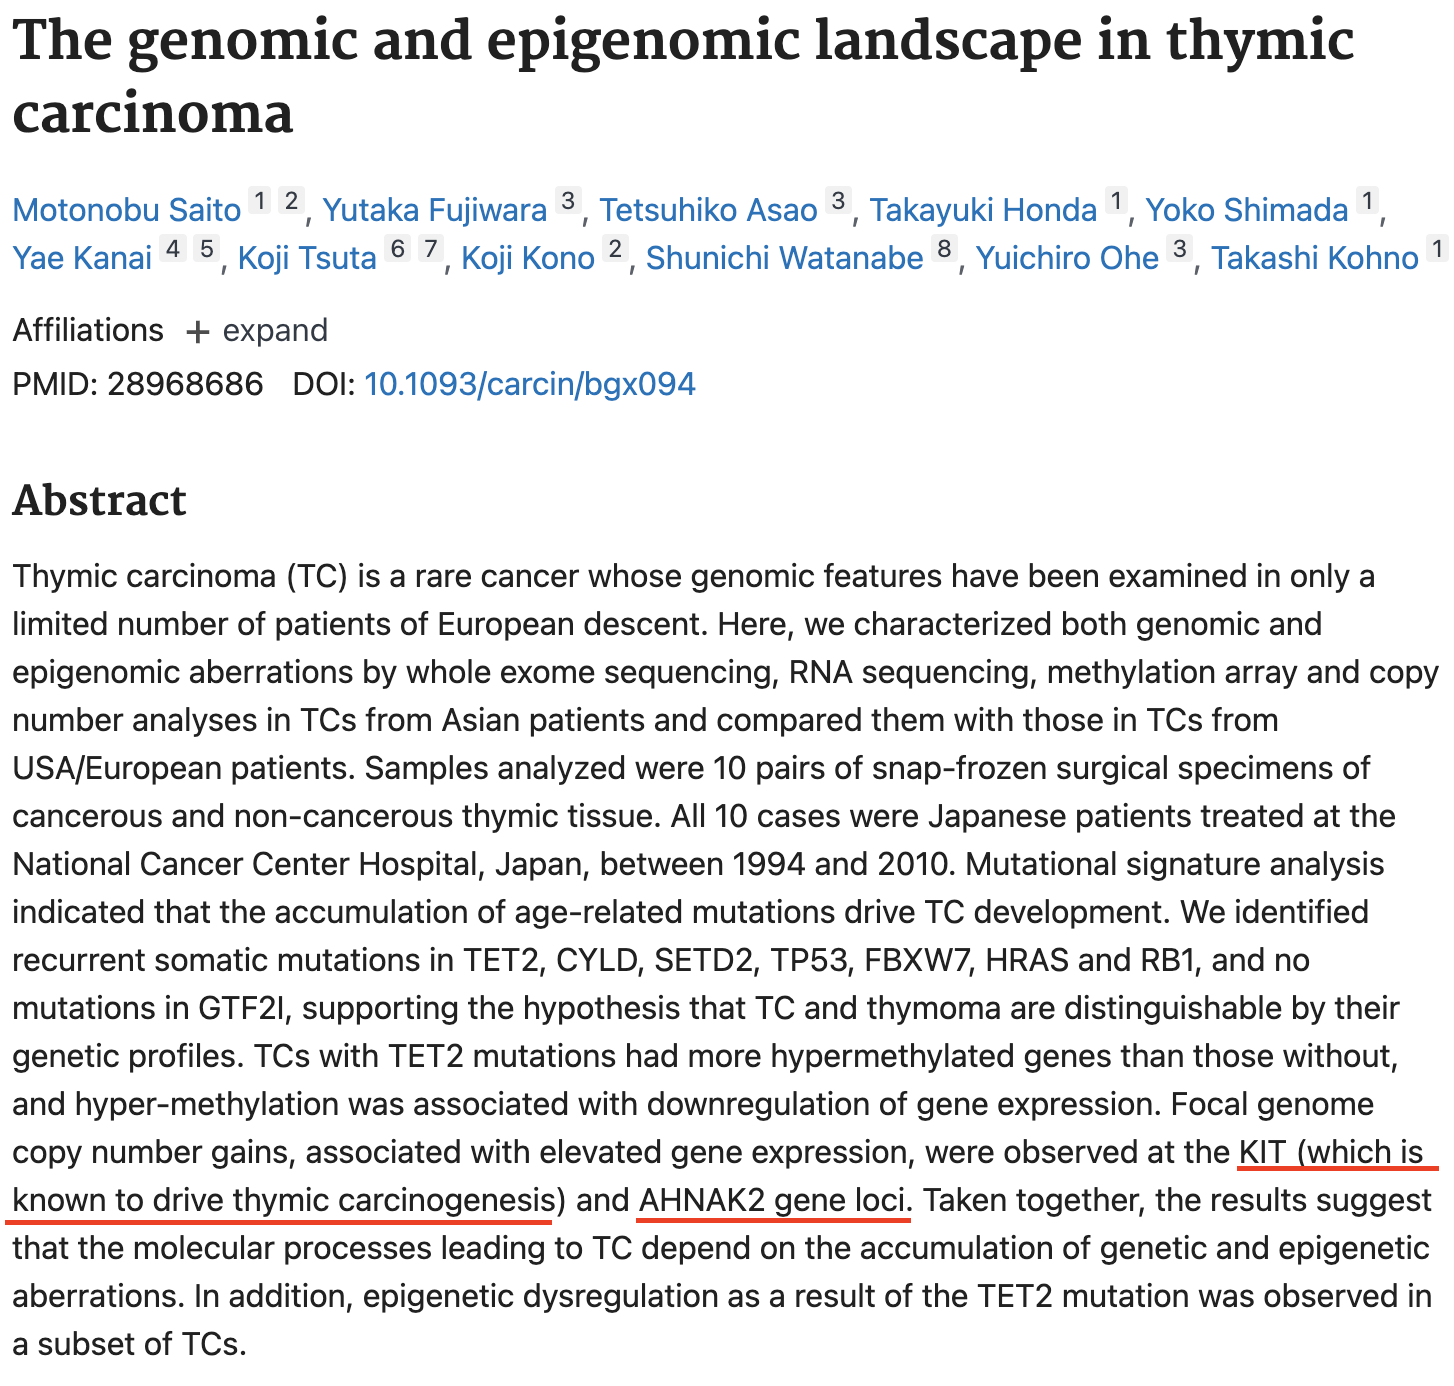

Но для большинства генов:

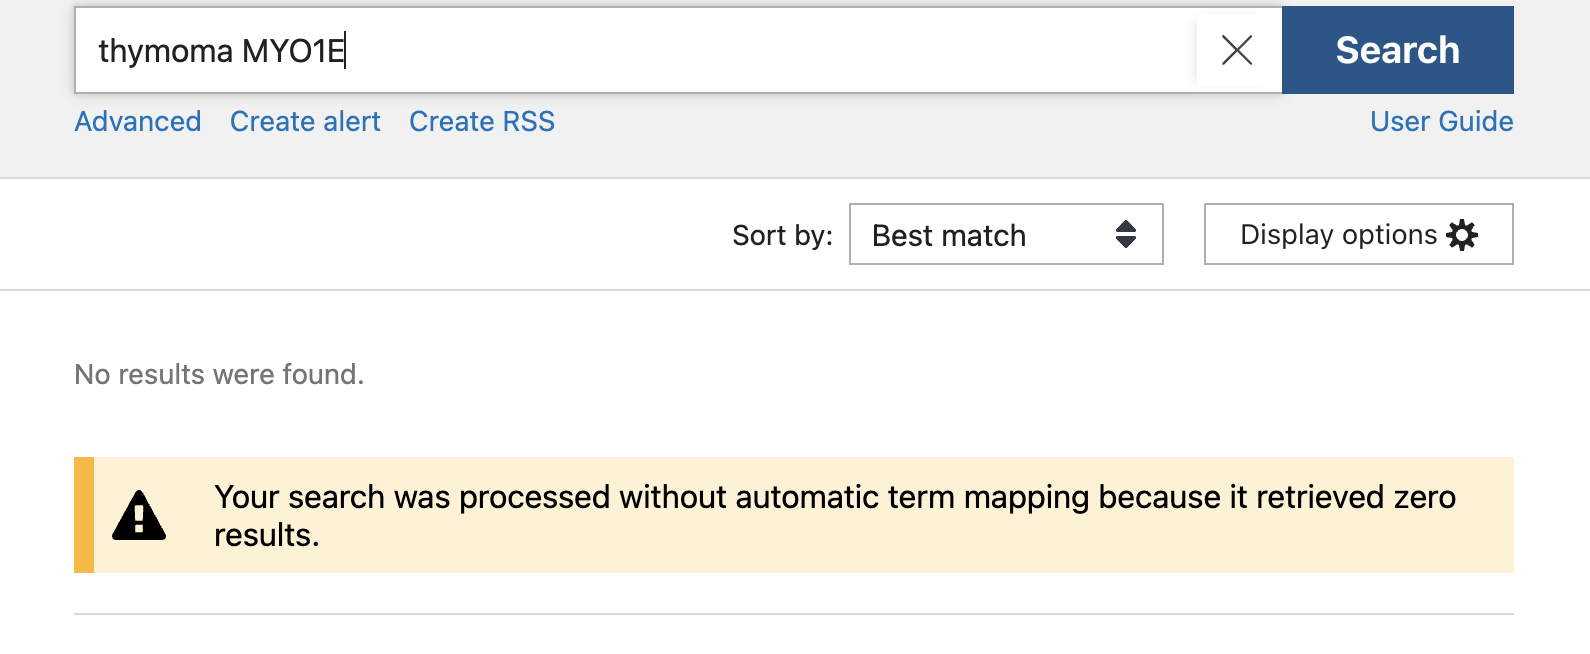

## Посмотрим на пути гистологического типа А

In [348]:
enr_top = gseapy.enrichr(gene_list=deg_A_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

Gene_set                                        Term  \
0  GO_Biological_Process_2021                DNA replication (GO:0006260)   
1  GO_Biological_Process_2021          DNA metabolic process (GO:0006259)   
2  GO_Biological_Process_2021                     DNA repair (GO:0006281)   
3  GO_Biological_Process_2021  DNA-dependent DNA replication (GO:0006261)   
4  GO_Biological_Process_2021     double-strand break repair (GO:0006302)   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  12/108  3.304550e-09          0.000006            0                     0   
1  15/277  6.144365e-07          0.000524            0                     0   
2  15/298  1.535427e-06          0.000765            0                     0   
3  10/129  2.035098e-06          0.000765            0                     0   
4  11/164  2.602399e-06          0.000765            0                     0   

   Odds Ratio  Combined Score  \
0   11.548709      225.522790   
1    5.319793       76.086657   
2    4.919738       65.859059   
3    7.682627      100.680564   
4    6.592206       84.769679   

                                               Genes  
0  WDHD1;RMI2;MCM8;EXO1;TIMELESS;WRNIP1;MCM10;DNA...  
1  GEN1;WDHD1;RMI2;MCM8;XRCC2;MCM10;CDC6;BRCA1;RA...  
2  WDHD1;RMI2;XRCC2;WRNIP1;BRCA1;RAD51D;SLX4;EME1...  
3  GINS1;WDHD1;PSMA6;MCM8;GINS4;WRNIP1;MCM10;DNA2...  
4  GEN1;RAD51D;SLX4;EME1;MCM8;XRCC2;DNA2;BRCA1;TR...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

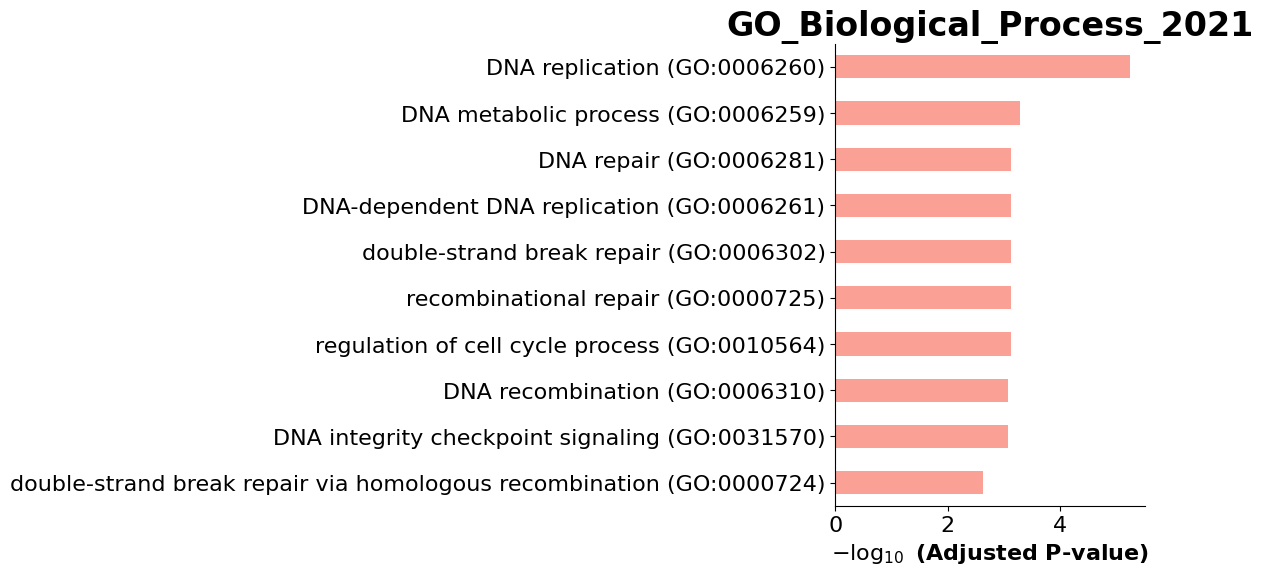

In [349]:
barplot(enr_top.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

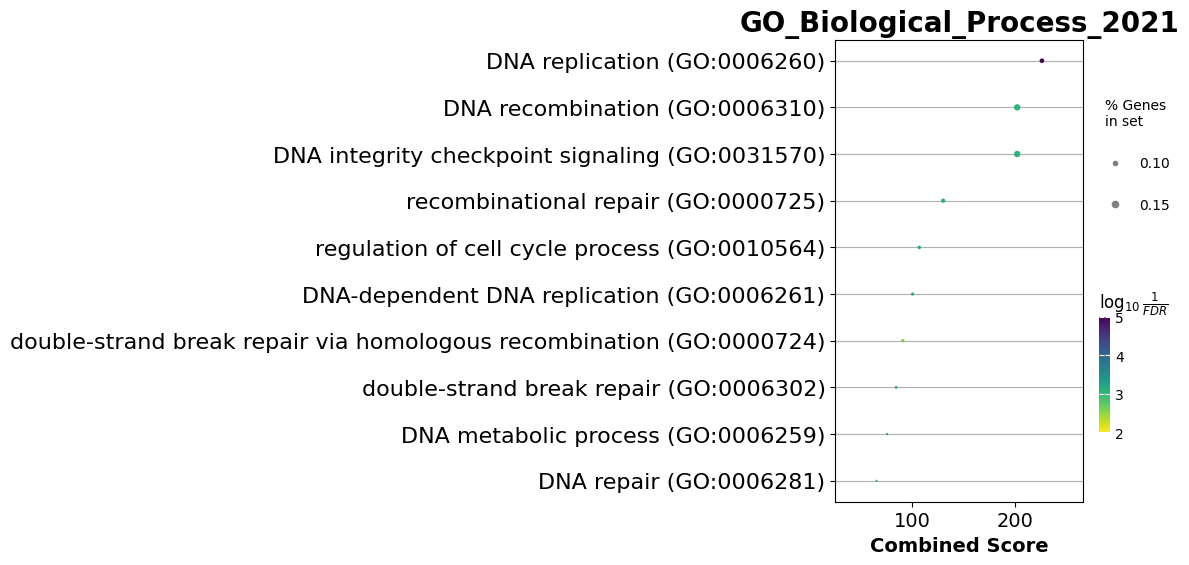

In [350]:
dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

# Очень интересно, практически все пути тем или иным образом связаны с обработкой ДНК. В том числе регуляция клеточного цикла. Я рискну предположить, что этот гистологический тип злокачественный

# Теперь Ab

In [355]:
len(deg_Ab_df.index.to_list())

138

In [351]:
enr_top = gseapy.enrichr(gene_list=deg_Ab_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0                     T cell activation (GO:0042110)    6/92  0.000042   
1  positive regulation of killing of cells of oth...     2/6  0.000696   
2  Fc-epsilon receptor signaling pathway (GO:0038...   5/111  0.001038   
3         Fc receptor signaling pathway (GO:0038093)   5/112  0.001081   
4  cellular response to cytokine stimulus (GO:007...  10/482  0.001910   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.044486            0                     0   10.452431   
1          0.283370            0                     0   73.007353   
2          0.283370            0                     0    7.006668   
3          0.283370            0                     0    6.940833   
4          0.329684            0                     0    3.209415   

   Combined Score                                              Genes  
0      105.236988                      ITK;CCL21;CD8A;LEPR;LAT;PTPN2  
1      530.750883                                         FCER2;NOS2  
2       48.139218                           VAV3;ITK;NFATC3;LCP2;LAT  
3       47.407971                           VAV3;ITK;NFATC3;LCP2;LAT  
4       20.093797  FCER2;TCL1A;COL1A2;CCL21;NOS2;MMP2;LEPR;SLA;TN...

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

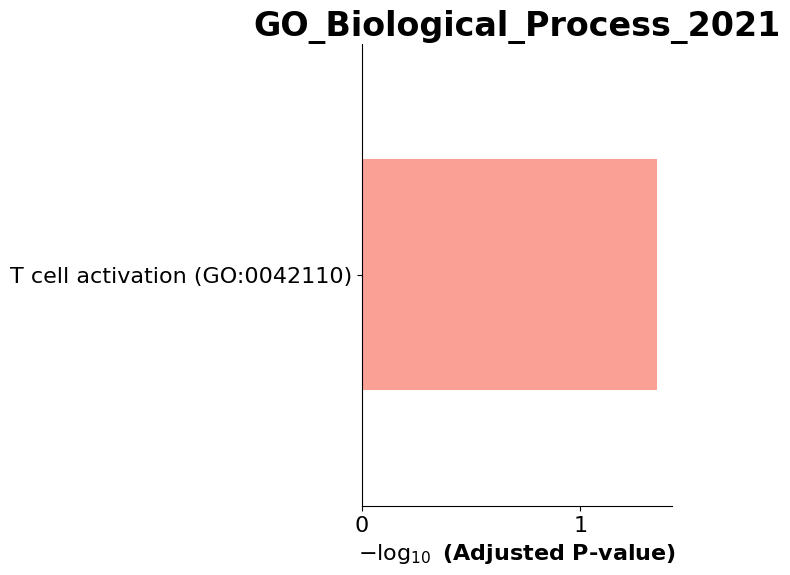

In [352]:
barplot(enr_top.res2d,title=gene_sets[1])

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

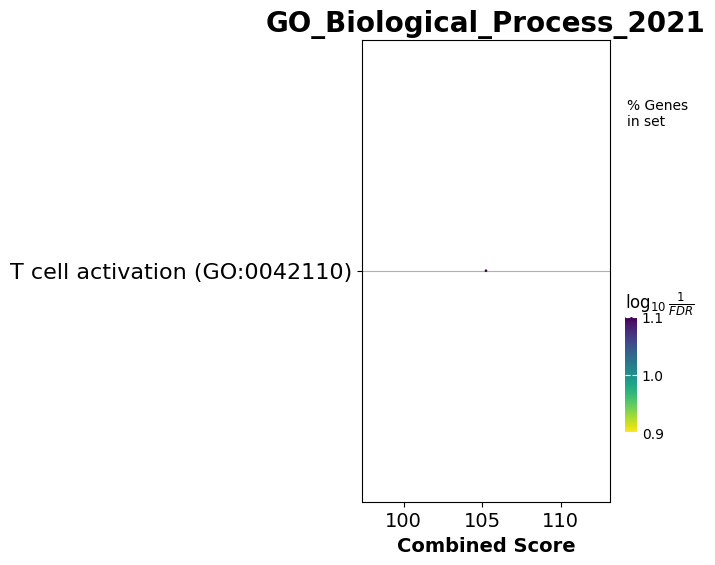

In [353]:
dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

# Тут ничего интересного не получилось. Не удивительный результат учитывая генез ткани

# C

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

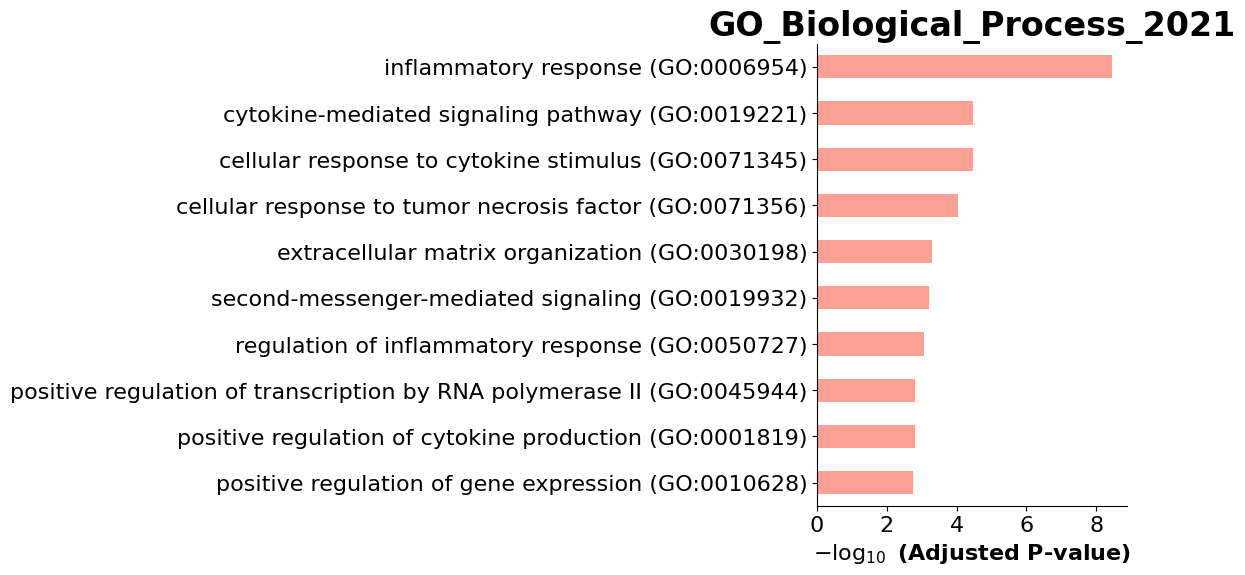

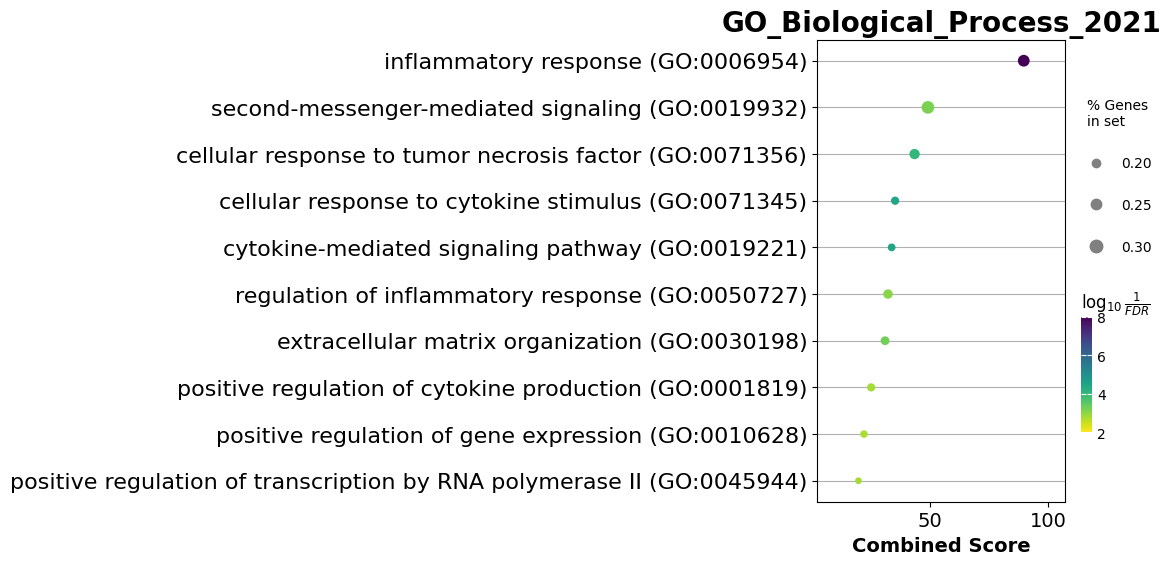

In [356]:
enr_top = gseapy.enrichr(gene_list=deg_C_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

barplot(enr_top.res2d,title=gene_sets[1])

dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

# В основном пути связанные с воспалением, продукцией цитокинов, внутриклеточный сигналлинг.

# B1

<Axes: title={'center': 'GO_Biological_Process_2021'}, xlabel='Combined Score'>

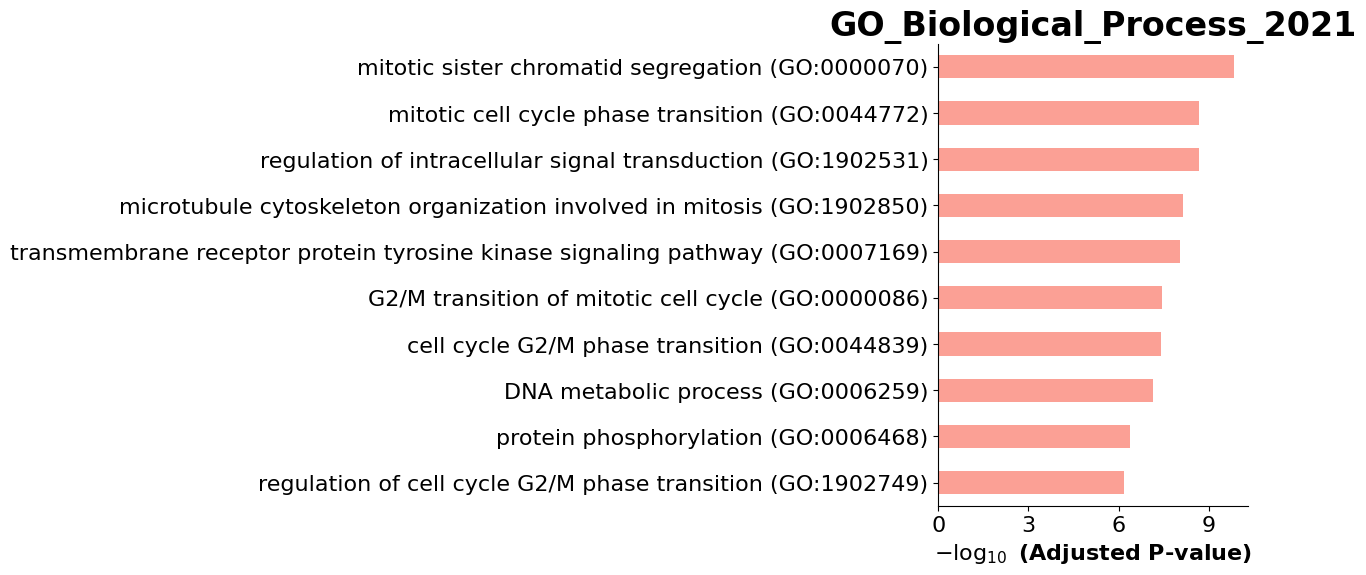

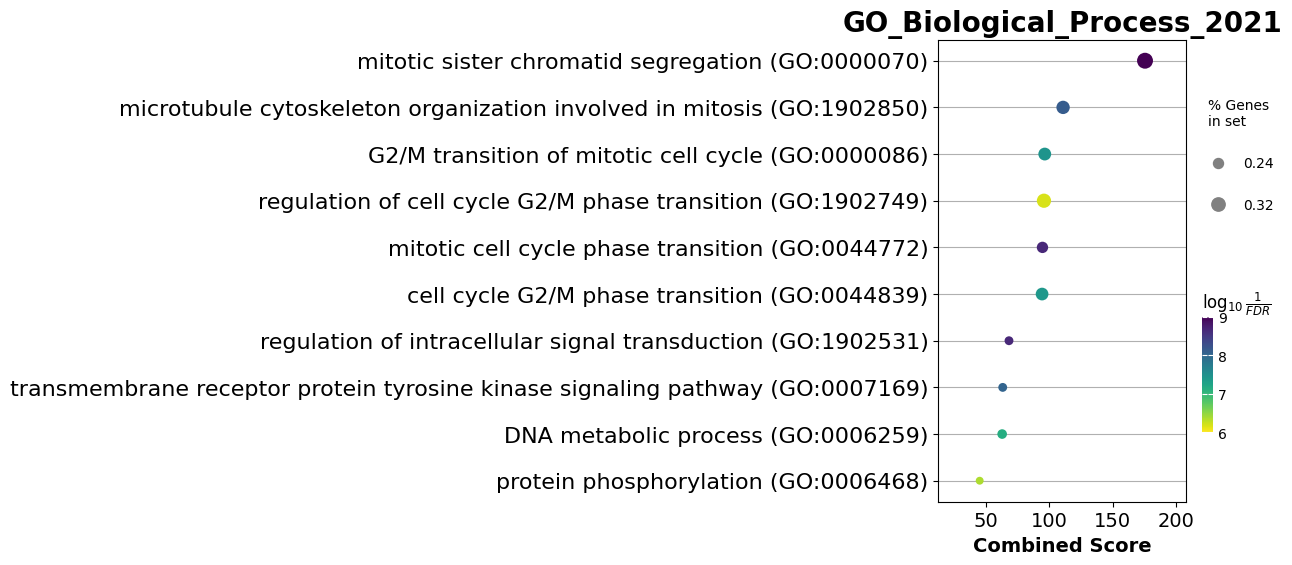

In [357]:
enr_top = gseapy.enrichr(gene_list=deg_B1_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

barplot(enr_top.res2d,title=gene_sets[1])

dotplot(enr_top.res2d, title = gene_sets[1],cmap='viridis_r')

# Пути преимущественно связанные с митозом и делением клетки. По всей видимости также злокачественный вариант, если судить исключительно по имеющимся данным

# B2

In [372]:
len(deg_B2_df.index.to_list())

99

In [377]:
enr_top = gseapy.enrichr(gene_list=deg_B2_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0          cellular response to alcohol (GO:0097306)    4/48  0.000093   
1  cellular response to organic substance (GO:007...   5/123  0.000366   
2         primary neural tube formation (GO:0014020)    3/30  0.000433   
3                          tube closure (GO:0060606)    3/31  0.000478   
4  glomerular epithelial cell development (GO:007...     2/7  0.000501   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.065362            0                     0   19.001914   
1          0.065362            0                     0    8.917688   
2          0.065362            0                     0   23.002315   
3          0.065362            0                     0   22.179688   
4          0.065362            0                     0   82.045361   

   Combined Score                            Genes  
0      176.396065            SMO;CTNNA1;ADCY6;LRP6  
1       70.574689  GHR;IL1RL2;ACVR1C;PTPN14;ACVR2A  
2      178.123913                 LMO4;SEMA4C;LRP6  
3      169.575740                 LMO4;SEMA4C;LRP6  
4      623.423794                       MYO1E;JAG1

# никакой закономерности...


# B3

In [373]:
len(deg_B2_df.index.to_list())

99

In [375]:
enr_top = gseapy.enrichr(gene_list=deg_B3_df.index.to_list(),
                 gene_sets=gene_sets[1],
                 organism='Human',
                 outdir='test/enrichr_go',
                 cutoff=0.5
                )

enr_top.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0          cellular response to hypoxia (GO:0071456)  11/131  0.000053   
1  organonitrogen compound biosynthetic process (...  12/158  0.000065   
2  regulation of transcription from RNA polymeras...    8/75  0.000105   
3  plus-end-directed organelle transport along mi...     3/6  0.000141   
4  regulation of primary metabolic process (GO:00...  10/130  0.000237   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.070158            0                     0    4.713940   
1          0.070158            0                     0    4.232224   
2          0.075295            0                     0    6.108619   
3          0.075750            0                     0   50.664083   
4          0.086957            0                     0    4.274123   

   Combined Score                                              Genes  
0       46.430072  PSMD12;PSMA3;PSMD11;PSMB5;PSMC6;FAM162A;UBC;PS...  
1       40.788246  CERS3;GSTK1;SGPL1;PCYT1A;CPS1;ARG1;MGST3;MGST2...  
2       55.963581    PSMA3;PSMD12;PSMD11;PSMB5;PSMC6;UBC;PSMC2;SIRT2  
3      449.274327                                  FYCO1;MAPT;KIFAP3  
4       35.683088  PSMD12;ZFP69;PSMA3;PSMD11;PSMB5;PSMC6;NFYB;PSM...

# интересно, клеточный ответ на гипоксию.